# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [334]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


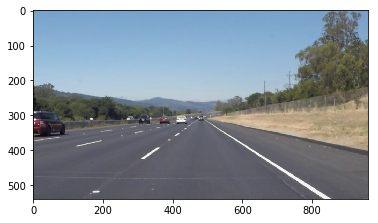

In [335]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [349]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            #print('Points and Slope', x1, y1, x2, y2, ((y2-y1)/(x2-x1)) )
   
def findX2GivenXYandSlope(x1, y1, y2, slope):
    """
    Given one point, a slope and y co-ordinate of other point in the line, find the x-xordinate.
    This helps in finding the missing extent of the lane if there are any missing white/yellow
    markings on the road.
    Inputs: x1, y1, y2, slope
    Returns: x2 (x co-ordinate of another poin in the line)
    """
    x2 = x1 + (y2-y1)/slope
    return x2

def find_line_end_points(lines, shape, slope_tolerance=0.05, min_line_length=15, mul_factor=1):
    """
    This function finds the end points of the line that is derived from the Hough lines list for a given slope
    (i.e left and right lanes).
    For each type of a lane, it finds ifthe line segment coming from Hough lines is having the following checks before
    it is condidered to be considered to be part of Lane end point detection.
        - the slope of the line segment is within 5% of the average slope of all other line segments in that direction.
        - The line segment to be considered for end point detection is of atleast 15 pixels in length
    
    Inputs: Hough line list - list of line segments
            shape of the image - to Find out the boundaries for the x, y 
            slope_tolarance - to find out if the line segment slope is withing the range of ave slopes of other lines
            min_line_length - Minimum size of line to be considered for lane end point detection
            mul_factor - positive number (1) for detecting positive slope and nagative number for detecting negative slope
    Returns: x1, y1, x2, y2 for the lane end points
    """
    x_max = 0
    y_max = 0
    x_min = shape[1]
    y_min = shape[0]
    aveSlope = 0
    slopeList = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            #check for the slope
            slope = (y2-y1)/(x2-x1)
            if ((slope*mul_factor) > 0):
                #print ('Tolerance Check', x_max, np.absolute(slope), np.absolute(np.average(slopeList)) )
                if (x_max == 0) or (((np.absolute(slope) < np.absolute(np.average(slopeList))+slope_tolerance) and (np.absolute(slope) > np.absolute(np.average(slopeList))-slope_tolerance))):
                    slopeList = np.append(slopeList, slope)

                    line_len = plt.mlab.dist(np.array([x1, y1]), np.array([x2, y2]))

                    if (line_len > min_line_length):
                    
                        #print('Pos Points and Slope', x1, y1, x2, y2, slope, line_len )
                        if (x1 < x_min):
                            x_min = x1
                            y_min = y1

                        if (x2 < x_min):
                            x_min = x2
                            y_min = y2

                        if (x1 > x_max):
                            x_max = x1
                            y_max = y1

                        if (x2 > x_max):
                            x_max = x2
                            y_max = y2
    return x_min, y_min, x_max, y_max
              
def draw_lines_enh(img, lines, vertices, color=[255, 0, 0], thickness=10, slope_threshold=0.3):
    """
    This function extends and fills the missing line segments for a lane based on the information 
    from the Hough Lines. This function basically extends the top and bottom portions of the line segment
    based on the slope of the already found line segment and fills upto the top and bottom portion
    of the region of interest.
    
    Inputs:
            img - Image on which the lines to be drawn
            lines - Hough lines info
            vertices - vertices for region of interest
            color - Color of the lines to drawn
            thikness - thickness of the line in pixels
            slope_threshold - Should be more than this Slope
    Output:
            Returns an image with lines drawn
    """
    #Pos Slope
    pos_points = find_line_end_points(lines, img.shape, .03, 15, 1)
    slope = ((pos_points[3]-pos_points[1])/(pos_points[2]-pos_points[0]))
    #print('Pos Points', pos_points, (slope))
    if (np.abs(slope) > slope_threshold):

        #Draw positive line
        cv2.line(img, (pos_points[0], pos_points[1]), (pos_points[2]-1, pos_points[3]), color, thickness)
        #Draw missing lines
        bX1 = pos_points[0]
        bY1 = pos_points[1]
        bY2 = vertices[0][3][1]

        x2 = findX2GivenXYandSlope(bX1, bY1, bY2, slope)
        #print('Found these for positive slope', bX1, bY1, x2, bY2, slope)
        cv2.line(img, (bX1, bY1), (int(x2), bY2), color, thickness)

        bX1 = pos_points[2]
        bY1 = pos_points[3]
        bY2 = vertices[0][2][1]
        x2 = findX2GivenXYandSlope(bX1, bY1, bY2, slope)
        #print('Found these for positive slope', bX1, bY1, x2, bY2, slope)
        cv2.line(img, (bX1, bY1), (int(x2), bY2), color, thickness)
    
    neg_points = find_line_end_points(lines, img.shape, .03, 15, (-1))
    neg_slope = ((neg_points[3]-neg_points[1])/(neg_points[2]-neg_points[0]))
    #print('Neg Points', neg_points, neg_slope)
    if (np.abs(neg_slope) > slope_threshold):
        cv2.line(img, (neg_points[0], neg_points[1]), (neg_points[2]-1, neg_points[3]), color, thickness)
        # Find the logic to extend the lines if they are not extended to the ends
        # Neg slope
        x1 = findX2GivenXYandSlope(neg_points[0], neg_points[1], vertices[0][0][1], ((neg_points[3]-neg_points[1])/(neg_points[2]-neg_points[0])))
        #print ('Found these for neg slope', neg_points[0], neg_points[1], int(x1), vertices[0][0][1])
        cv2.line(img, (neg_points[0], neg_points[1]), (int(x1), vertices[0][0][1]), color, thickness)
        x1 = findX2GivenXYandSlope(neg_points[2], neg_points[3], vertices[0][1][1], ((neg_points[3]-neg_points[1])/(neg_points[2]-neg_points[0])))
        #print ('Found these for neg slope', neg_points[2], neg_points[3], int(x1), vertices[0][1][1])
        cv2.line(img, (neg_points[2], neg_points[3]), (int(x1), vertices[0][1][1]), color, thickness)
    

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, vertices):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines_enh(line_img, lines, vertices)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [350]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [353]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def processImageForHoughLines(image):

    gray_image = grayscale(image)
    #Now apply gaussian blur with kernel size = 5 on the gray image
    blur_gray = gaussian_blur(gray_image, 5)

    # Get Edges using Canny algo
    low_threshold = 50
    high_threshold = 150
    image_with_edge = canny(blur_gray, low_threshold, high_threshold)

    # Let us define the vertices for the region of interest to find the Lanes
    imshape = image.shape
    vertices = np.array([[(150,imshape[0]),(400, 320), (550, 320), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    image_with_masked_edges = region_of_interest(image_with_edge, vertices)
    

    # Let us get Hough lines applied on the image
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 2    # maximum gap in pixels between connectable line segments

    hough_lines_image = hough_lines(image_with_masked_edges, rho, theta, threshold, min_line_length, max_line_gap, vertices)

    # Let us draw the hough lines on the initial image
    combined_image = weighted_img(hough_lines_image, image)
    """
    plt.figure()
    plt.imshow(blur_gray, cmap='gray')
    plt.figure()
    plt.imshow(image_with_edge, cmap='gray')
    plt.figure()
    plt.imshow(image_with_masked_edges, cmap='gray')
    plt.figure()
    plt.imshow(combined_image)
    """
    return combined_image


540 960


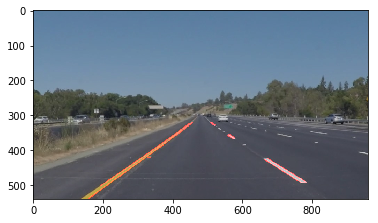

In [354]:
image = mpimg.imread('test_images/' +'solidYellowLeft.jpg')
processed_image = processImageForHoughLines(image)
print (processed_image.shape[0], processed_image.shape[1])
plt.figure()
plt.imshow(processed_image)

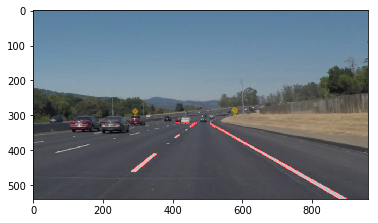

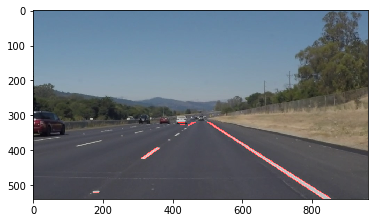

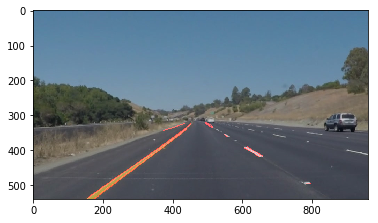

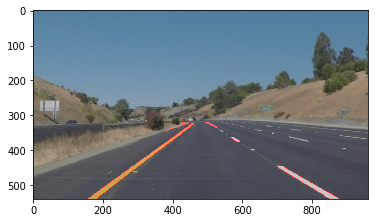

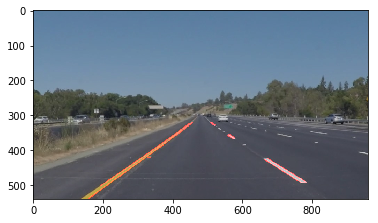

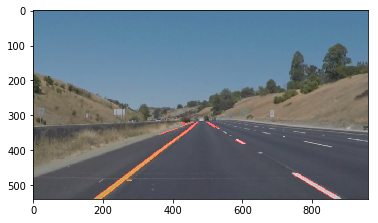

In [355]:
for imageFileName in os.listdir("test_images/"):
    image = mpimg.imread('test_images/' +imageFileName)
    processed_image = processImageForHoughLines(image)
    #save the image in test_output folder
    mpimg.imsave('test_images_output/' +imageFileName, processed_image)
    plt.figure()
    plt.imshow(processed_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [331]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [332]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = processImageForHoughLines(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [333]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Pos Points (502, 320, 869, 539) 0.596730245232
Found these for positive slope 502 320 870.675799087 540 0.596730245232
Found these for positive slope 869 539 502.0 320 0.596730245232
Neg Points (187, 513, 455, 320) -0.720149253731
Found these for neg slope 187 513 149 540
Found these for neg slope 455 320 455 320
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  7%|▋         | 9/126 [00:00<00:01, 81.40it/s]

Pos Points (502, 320, 869, 539) 0.596730245232
Found these for positive slope 502 320 870.675799087 540 0.596730245232
Found these for positive slope 869 539 502.0 320 0.596730245232
Neg Points (187, 513, 455, 320) -0.720149253731
Found these for neg slope 187 513 149 540
Found these for neg slope 455 320 455 320
Pos Points (501, 320, 867, 538) 0.595628415301
Found these for positive slope 501 320 870.357798165 540 0.595628415301
Found these for positive slope 867 538 501.0 320 0.595628415301
Neg Points (174, 536, 289, 449) -0.75652173913
Found these for neg slope 174 536 168 540
Found these for neg slope 289 449 459 320
Pos Points (501, 320, 868, 538) 0.594005449591
Found these for positive slope 501 320 871.366972477 540 0.594005449591
Found these for positive slope 868 538 501.0 320 0.594005449591
Neg Points (170, 538, 456, 320) -0.762237762238
Found these for neg slope 170 538 167 540
Found these for neg slope 456 320 456 320
Pos Points (501, 320, 868, 539) 0.596730245232
Found the

 21%|██▏       | 27/126 [00:00<00:01, 82.15it/s]

505.0 320 0.659638554217
Neg Points (365, 385, 389, 369) -0.666666666667
Found these for neg slope 365 385 132 540
Found these for neg slope 389 369 462 320
Pos Points (504, 320, 857, 539) 0.620396600567
Found these for positive slope 504 320 858.611872146 540 0.620396600567
Found these for positive slope 857 539 504.0 320 0.620396600567
Neg Points (350, 391, 451, 321) -0.693069306931
Found these for neg slope 350 391 135 540
Found these for neg slope 451 321 452 320
Pos Points (502, 320, 856, 538) 0.61581920904
Found these for positive slope 502 320 859.247706422 540 0.61581920904
Found these for positive slope 856 538 502.0 320 0.61581920904
Neg Points (346, 402, 377, 380) -0.709677419355
Found these for neg slope 346 402 151 540
Found these for neg slope 377 380 461 320
Pos Points (501, 321, 855, 538) 0.612994350282
Found these for positive slope 501 321 858.262672811 540 0.612994350282
Found these for positive slope 855 538 499.368663594 320 0.612994350282
Neg Points (335, 412, 370

 35%|███▍      | 44/126 [00:00<00:01, 80.77it/s]

358 389 456 320
Pos Points (502, 320, 858, 539) 0.615168539326
Found these for positive slope 502 320 859.625570776 540 0.615168539326
Found these for positive slope 858 539 502.0 320 0.615168539326
Neg Points (301, 437, 353, 399) -0.730769230769
Found these for neg slope 301 437 160 540
Found these for neg slope 353 399 461 320
Pos Points (501, 320, 856, 538) 0.614084507042
Found these for positive slope 501 320 859.256880734 540 0.614084507042
Found these for positive slope 856 538 501.0 320 0.614084507042
Neg Points (267, 452, 336, 406) -0.666666666667
Found these for neg slope 267 452 135 540
Found these for neg slope 336 406 465 320
Pos Points (501, 320, 854, 539) 0.620396600567
Found these for positive slope 501 320 855.611872146 540 0.620396600567
Found these for positive slope 854 539 501.0 320 0.620396600567
Neg Points (248, 478, 457, 320) -0.755980861244
Found these for neg slope 248 478 165 540
Found these for neg slope 457 320 457 320
Pos Points (689, 437, 855, 538) 0.60843

 46%|████▌     | 58/126 [00:00<00:00, 71.58it/s]


Pos Points (508, 320, 854, 538) 0.630057803468
Found these for positive slope 508 320 857.174311927 540 0.630057803468
Found these for positive slope 854 538 508.0 320 0.630057803468
Neg Points (213, 501, 402, 355) -0.772486772487
Found these for neg slope 213 501 162 540
Found these for neg slope 402 355 447 320
Pos Points (502, 320, 853, 539) 0.623931623932
Found these for positive slope 502 320 854.602739726 540 0.623931623932
Found these for positive slope 853 539 502.0 320 0.623931623932
Neg Points (161, 538, 401, 361) -0.7375
Found these for neg slope 161 538 158 540
Found these for neg slope 401 361 456 320
Pos Points (502, 320, 831, 539) 0.665653495441
Found these for positive slope 502 320 832.502283105 540 0.665653495441
Found these for positive slope 831 539 502.0 320 0.665653495441
Neg Points (160, 538, 397, 364) -0.73417721519
Found these for neg slope 160 538 157 540
Found these for neg slope 397 364 456 320
Pos Points (503, 320, 852, 538) 0.624641833811
Found these for 

 58%|█████▊    | 73/126 [00:00<00:00, 68.13it/s]

320 0.632947976879
Neg Points (151, 539, 457, 320) -0.71568627451
Found these for neg slope 151 539 149 540
Found these for neg slope 457 320 457 320
Pos Points (503, 320, 844, 539) 0.642228739003
Found these for positive slope 503 320 845.557077626 540 0.642228739003
Found these for positive slope 844 539 503.0 320 0.642228739003
Neg Points (153, 537, 252, 466) -0.717171717172
Found these for neg slope 153 537 148 540
Found these for neg slope 252 466 455 320
Pos Points (497, 320, 843, 539) 0.632947976879
Found these for positive slope 497 320 844.579908676 540 0.632947976879
Found these for positive slope 843 539 497.0 320 0.632947976879
Neg Points (157, 534, 215, 492) -0.724137931034
Found these for neg slope 157 534 148 540
Found these for neg slope 215 492 452 320
Pos Points (502, 320, 842, 538) 0.641176470588
Found these for positive slope 502 320 845.119266055 540 0.641176470588
Found these for positive slope 842 538 502.0 320 0.641176470588
Neg Points (357, 386, 457, 320) -0.66

 69%|██████▉   | 87/126 [00:01<00:00, 66.34it/s]

 320 0.631901840491
Neg Points (184, 510, 394, 364) -0.695238095238
Found these for neg slope 184 510 140 540
Found these for neg slope 394 364 457 320
Pos Points (500, 320, 841, 539) 0.642228739003
Found these for positive slope 500 320 842.557077626 540 0.642228739003
Found these for positive slope 841 539 500.0 320 0.642228739003
Neg Points (188, 506, 390, 366) -0.693069306931
Found these for neg slope 188 506 138 540
Found these for neg slope 390 366 456 320
Pos Points (511, 328, 840, 539) 0.641337386018
Found these for positive slope 511 328 841.559241706 540 0.641337386018
Found these for positive slope 840 539 498.526066351 320 0.641337386018
Neg Points (360, 385, 384, 369) -0.666666666667
Found these for neg slope 360 385 127 540
Found these for neg slope 384 369 457 320
Pos Points (499, 320, 839, 538) 0.641176470588
Found these for positive slope 499 320 842.119266055 540 0.641176470588
Found these for positive slope 839 538 499.0 320 0.641176470588
Neg Points (350, 392, 451, 

 80%|████████  | 101/126 [00:01<00:00, 66.70it/s]

 0.678125
Neg Points (448, 328, 461, 320) -0.615384615385
Found these for neg slope 448 328 103 540
Found these for neg slope 461 320 461 320
Pos Points (501, 320, 809, 539) 0.711038961039
Found these for positive slope 501 320 810.406392694 540 0.711038961039
Found these for positive slope 809 539 501.0 320 0.711038961039
Neg Points (344, 393, 460, 320) -0.629310344828
Found these for neg slope 344 393 110 540
Found these for neg slope 460 320 460 320
Pos Points (636, 411, 811, 526) 0.657142857143
Found these for positive slope 636 411 832.304347826 540 0.657142857143
Found these for positive slope 811 526 497.52173913 320 0.657142857143
Neg Points (334, 400, 446, 326) -0.660714285714
Found these for neg slope 334 400 122 540
Found these for neg slope 446 326 455 320
Pos Points (507, 320, 829, 538) 0.67701863354
Found these for positive slope 507 320 831.95412844 540 0.67701863354
Found these for positive slope 829 538 507.0 320 0.67701863354
Neg Points (328, 410, 456, 320) -0.703125


 86%|████████▌ | 108/126 [00:01<00:00, 63.41it/s]

 320 833.470319635 540 0.680124223602
Found these for positive slope 832 539 510.0 320 0.680124223602
Neg Points (349, 399, 377, 379) -0.714285714286
Found these for neg slope 349 399 151 540
Found these for neg slope 377 379 459 320
Pos Points (503, 320, 808, 521) 0.659016393443
Found these for positive slope 503 320 836.830845771 540 0.659016393443
Found these for positive slope 808 521 503.0 320 0.659016393443
Neg Points (335, 410, 370, 385) -0.714285714286
Found these for neg slope 335 410 153 540
Found these for neg slope 370 385 461 320
Pos Points (504, 320, 834, 538) 0.660606060606
Found these for positive slope 504 320 837.027522936 540 0.660606060606
Found these for positive slope 834 538 504.0 320 0.660606060606
Neg Points (311, 418, 357, 389) -0.630434782609
Found these for neg slope 311 418 117 540
Found these for neg slope 357 389 466 320
Pos Points (505, 320, 836, 539) 0.66163141994
Found these for positive slope 505 320 837.511415525 540 0.66163141994
Found these for pos

 99%|█████████▉| 125/126 [00:01<00:00, 67.30it/s]

Found these for positive slope 844 538 506.0 320 0.644970414201
Neg Points (343, 395, 457, 320) -0.657894736842
Found these for neg slope 343 395 122 540
Found these for neg slope 457 320 457 320
Pos Points (506, 320, 824, 538) 0.685534591195
Found these for positive slope 506 320 826.917431193 540 0.685534591195
Found these for positive slope 824 538 506.0 320 0.685534591195
Neg Points (337, 406, 371, 382) -0.705882352941
Found these for neg slope 337 406 147 540
Found these for neg slope 371 382 458 320
Pos Points (558, 354, 825, 539) 0.692883895131
Found these for positive slope 558 354 826.443243243 540 0.692883895131
Found these for positive slope 825 539 508.92972973 320 0.692883895131
Neg Points (314, 416, 363, 388) -0.571428571429
Found these for neg slope 314 416 97 540
Found these for neg slope 363 388 482 320
Pos Points (504, 320, 846, 539) 0.640350877193
Found these for positive slope 504 320 847.561643836 540 0.640350877193
Found these for positive slope 846 539 504.0 320 

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 1.88 s, sys: 1.19 s, total: 3.07 s
Wall time: 2.25 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [277]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [278]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Pos Points (563, 359, 759, 497) 0.704081632653
Found these for positive slope 563 359 820.072463768 540 0.704081632653
Found these for positive slope 759 497 507.608695652 320 0.704081632653
Neg Points (220, 478, 446, 330) -0.654867256637
Found these for neg slope 220 478 125 540
Found these for neg slope 446 330 461 320
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  1%|▏         | 9/682 [00:00<00:07, 85.90it/s]

Pos Points (563, 359, 759, 497) 0.704081632653
Found these for positive slope 563 359 820.072463768 540 0.704081632653
Found these for positive slope 759 497 507.608695652 320 0.704081632653
Neg Points (220, 478, 446, 330) -0.654867256637
Found these for neg slope 220 478 125 540
Found these for neg slope 446 330 461 320
Pos Points (686, 439, 719, 460) 0.636363636364
Found these for positive slope 686 439 844.714285714 540 0.636363636364
Found these for positive slope 719 460 499.0 320 0.636363636364
Neg Points (217, 481, 426, 344) -0.655502392344
Found these for neg slope 217 481 126 540
Found these for neg slope 426 344 462 320
Pos Points (571, 366, 826, 529) 0.639215686275
Found these for positive slope 571 366 843.208588957 540 0.639215686275
Found these for positive slope 826 529 499.036809816 320 0.639215686275
Neg Points (218, 480, 449, 328) -0.658008658009
Found these for neg slope 218 480 126 540
Found these for neg slope 449 328 461 320
Pos Points (576, 368, 820, 538) 0.69672

  4%|▍         | 27/682 [00:00<00:07, 84.12it/s]

Pos Points (592, 372, 613, 386) 0.666666666667
Found these for positive slope 592 372 844.0 540 0.666666666667
Found these for positive slope 613 386 514.0 320 0.666666666667
Neg Points (156, 538, 426, 344) -0.718518518519
Found these for neg slope 156 538 153 540
Found these for neg slope 426 344 459 320
Pos Points (593, 376, 621, 396) 0.714285714286
Found these for positive slope 593 376 822.6 540 0.714285714286
Found these for positive slope 621 396 514.6 320 0.714285714286
Neg Points (154, 538, 429, 346) -0.698181818182
Found these for neg slope 154 538 151 540
Found these for neg slope 429 346 466 320
Pos Points (600, 381, 635, 404) 0.657142857143
Found these for positive slope 600 381 841.956521739 540 0.657142857143
Found these for positive slope 635 404 507.173913043 320 0.657142857143
Neg Points (155, 539, 424, 344) -0.724907063197
Found these for neg slope 155 539 153 540
Found these for neg slope 424 344 457 320
Pos Points (608, 386, 657, 411) 0.510204081633
Found these for 

  6%|▋         | 43/682 [00:00<00:08, 78.81it/s]

 (621, 389, 660, 415) 0.666666666667
Found these for positive slope 621 389 847.5 540 0.666666666667
Found these for positive slope 660 415 517.5 320 0.666666666667
Neg Points (165, 538, 401, 358) -0.762711864407
Found these for neg slope 165 538 162 540
Found these for neg slope 401 358 450 320
Pos Points (556, 347, 861, 537) 0.622950819672
Found these for positive slope 556 347 865.815789474 540 0.622950819672
Found these for positive slope 861 537 512.657894737 320 0.622950819672
Neg Points (165, 538, 409, 352) -0.762295081967
Found these for neg slope 165 538 162 540
Found these for neg slope 409 352 450 320
Pos Points (645, 399, 714, 440) 0.594202898551
Found these for positive slope 645 399 882.292682927 540 0.594202898551
Found these for positive slope 714 440 512.048780488 320 0.594202898551
Neg Points (204, 510, 426, 338) -0.774774774775
Found these for neg slope 204 510 165 540
Found these for neg slope 426 338 449 320
Pos Points (652, 409, 724, 455) 0.638888888889
Found thes

  8%|▊         | 57/682 [00:00<00:09, 68.29it/s]

Pos Points (556, 347, 678, 429) 0.672131147541
Found these for positive slope 556 347 843.146341463 540 0.672131147541
Found these for positive slope 678 429 515.829268293 320 0.672131147541
Neg Points (170, 522, 445, 322) -0.727272727273
Found these for neg slope 170 522 145 540
Found these for neg slope 445 322 447 320
Pos Points (557, 352, 726, 449) 0.573964497041
Found these for positive slope 557 352 884.546391753 540 0.573964497041
Found these for positive slope 726 449 501.24742268 320 0.573964497041
Neg Points (165, 539, 447, 320) -0.776595744681
Found these for neg slope 165 539 163 540
Found these for neg slope 447 320 447 320
Pos Points (562, 351, 761, 469) 0.592964824121
Found these for positive slope 562 351 880.737288136 540 0.592964824121
Found these for positive slope 761 469 509.720338983 320 0.592964824121
Neg Points (170, 535, 450, 322) -0.760714285714
Found these for neg slope 170 535 163 540
Found these for neg slope 450 322 452 320
Pos Points (564, 356, 807, 496) 

  9%|▉         | 64/682 [00:00<00:09, 63.97it/s]

Pos Points (631, 401, 694, 441) 0.634920634921
Found these for positive slope 631 401 849.925 540 0.634920634921
Found these for positive slope 694 441 503.425 320 0.634920634921
Neg Points (159, 538, 427, 337) -0.75
Found these for neg slope 159 538 156 540
Found these for neg slope 427 337 449 320
Pos Points (560, 351, 722, 458) 0.66049382716
Found these for positive slope 560 351 846.14953271 540 0.66049382716
Found these for positive slope 722 458 513.065420561 320 0.66049382716
Neg Points (163, 534, 448, 320) -0.750877192982
Found these for neg slope 163 534 155 540
Found these for neg slope 448 320 448 320
Pos Points (562, 353, 757, 480) 0.651282051282
Found these for positive slope 562 353 849.125984252 540 0.651282051282
Found these for positive slope 757 480 511.330708661 320 0.651282051282
Neg Points (156, 538, 448, 320) -0.746575342466
Found these for neg slope 156 538 153 540
Found these for neg slope 448 320 448 320
Pos Points (563, 357, 804, 509) 0.630705394191
Found thes

 10%|█         | 71/682 [00:01<00:09, 63.82it/s]

540 0.568181818182
Found these for positive slope 649 407 495.88 320 0.568181818182
Neg Points (158, 539, 451, 320) -0.747440273038
Found these for neg slope 158 539 156 540
Found these for neg slope 451 320 451 320
Pos Points (631, 398, 667, 418) 0.555555555556
Found these for positive slope 631 398 886.6 540 0.555555555556
Found these for positive slope 667 418 490.6 320 0.555555555556
Neg Points (157, 538, 451, 320) -0.741496598639
Found these for neg slope 157 538 154 540
Found these for neg slope 451 320 451 320
Pos Points (626, 395, 686, 430)

 11%|█▏        | 78/682 [00:01<00:09, 63.38it/s]

 0.583333333333
Found these for positive slope 626 395 874.571428571 540 0.583333333333
Found these for positive slope 686 430 497.428571429 320 0.583333333333
Neg Points (157, 539, 444, 330) -0.728222996516
Found these for neg slope 157 539 155 540
Found these for neg slope 444 330 457 320
Pos Points (632, 405, 700, 448) 0.632352941176
Found these for positive slope 632 405 845.488372093 540 0.632352941176
Found these for positive slope 700 448 497.581395349 320 0.632352941176
Neg Points (157, 539, 447, 324) -0.741379310345
Found these for neg slope 157 539 155 540
Found these for neg slope 447 324 452 320
Pos Points (559, 353, 729, 467) 0.670588235294
Found these for positive slope 559 353 837.859649123 540 0.670588235294
Found these for positive slope 729 467 509.789473684 320 0.670588235294
Neg Points (158, 538, 446, 325) -0.739583333333
Found these for neg slope 158 538 155 540
Found these for neg slope 446 325 452 320
Pos Points (565, 358, 768, 493) 0.665024630542
Found these for

 12%|█▏        | 85/682 [00:01<00:09, 65.05it/s]

445 329 457 320
Pos Points (618, 397, 687, 434) 0.536231884058
Found these for positive slope 618 397 884.675675676 540 0.536231884058
Found these for positive slope 687 434 474.405405405 320 0.536231884058
Neg Points (154, 538, 449, 326) -0.718644067797
Found these for neg slope 154 538 151 540
Found these for neg slope 449 326 457 320
Pos Points

 13%|█▎        | 92/682 [00:01<00:09, 61.70it/s]

 (628, 403, 685, 440) 0.649122807018
Found these for positive slope 628 403 839.054054054 540 0.649122807018
Found these for positive slope 685 440 500.135135135 320 0.649122807018
Neg Points (152, 538, 432, 334) -0.728571428571
Found these for neg slope 152 538 149 540
Found these for neg slope 432 334 451 320
Pos Points (555, 354, 751, 472) 0.602040816327
Found these for positive slope 555 354 863.949152542 540 0.602040816327
Found these for positive slope 751 472 498.525423729 320 0.602040816327
Neg Points (153, 537, 450, 325) -0.713804713805
Found these for neg slope 153 537 148 540
Found these for neg slope 450 325 457 320
Pos Points (558, 357, 797, 499) 0.594142259414
Found these for positive slope 558 357 866.007042254 540 0.594142259414
Found these for positive slope 797 499 495.725352113 320 0.594142259414
Neg Points (218, 480, 436, 332) -0.678899082569
Found these for neg slope 218 480 129 540
Found these for neg slope 436 332 453 320
Pos Points (562, 359, 859, 539) 0.6060606

 16%|█▌        | 107/682 [00:01<00:09, 63.10it/s]

Pos Points (562, 356, 732, 463) 0.629411764706
Found these for positive slope 562 356 854.336448598 540 0.629411764706
Found these for positive slope 732 463 504.803738318 320 0.629411764706
Neg Points (156, 538, 455, 320) -0.729096989967
Found these for neg slope 156 538 153 540
Found these for neg slope 455 320 455 320
Pos Points (560, 360, 771, 487) 0.601895734597
Found these for positive slope 560 360 859.05511811 540 0.601895734597
Found these for positive slope 771 487 493.543307087 320 0.601895734597
Neg Points (156, 538, 453, 321) -0.73063973064
Found these for neg slope 156 538 153 540
Found these for neg slope 453 321 454 320
Pos Points (682, 441, 825, 520) 0.552447552448
Found these for positive slope 682 441 861.202531646 540 0.552447552448
Found these for positive slope 825 520 462.974683544 320 0.552447552448
Neg Points (155, 538, 447, 326) -0.72602739726
Found these for neg slope 155 538 152 540
Found these for neg slope 447 326 455 320
Pos Points (572, 363, 854, 538) 0.

 18%|█▊        | 121/682 [00:01<00:08, 64.47it/s]

463 320 463 320
Pos Points (560, 359, 757, 477) 0.598984771574
Found these for positive slope 560 359 862.177966102 540 0.598984771574
Found these for positive slope 757 477 494.889830508 320 0.598984771574
Neg Points (157, 538, 462, 321) -0.711475409836
Found these for neg slope 157 538 154 540
Found these for neg slope 462 321 463 320
Pos Points (567, 360, 795, 500) 0.614035087719
Found these for positive slope 567 360 860.142857143 540 0.614035087719
Found these for positive slope 795 500 501.857142857 320 0.614035087719
Neg Points (194, 501, 463, 320) -0.672862453532
Found these for neg slope 194 501 136 540
Found these for neg slope 463 320 463 320
Pos Points (569, 365, 837, 538) 0.64552238806
Found these for positive slope 569 365 840.098265896 540 0.64552238806
Found these for positive slope 837 538 499.289017341 320 0.64552238806
Neg Points (157, 538, 463, 320) -0.712418300654
Found these for neg slope 157 538 154 540
Found these for neg slope 463 320 463 320
Pos Points (504, 3

 20%|█▉        | 135/682 [00:02<00:08, 65.38it/s]

 501.328571429 320 0.654205607477
Neg Points (164, 538, 461, 320) -0.734006734007
Found these for neg slope 164 538 161 540
Found these for neg slope 461 320 461 320
Pos Points (688, 442, 838, 538) 0.64
Found these for positive slope 688 442 841.125 540 0.64
Found these for positive slope 838 538 497.375 320 0.64
Neg Points (165, 538, 457, 327) -0.722602739726
Found these for neg slope 165 538 162 540
Found these for neg slope 457 327 466 320
Pos Points (501, 320, 860, 538) 0.607242339833
Found these for positive slope 501 320 863.293577982 540 0.607242339833
Found these for positive slope 860 538 501.0 320 0.607242339833
Neg Points (178, 515, 468, 320) -0.672413793103
Found these for neg slope 178 515 140 540
Found these for neg slope 468 320 468 320
Pos Points (517, 326, 860, 539) 0.620991253644
Found these for positive slope 517 326 861.610328638 540 0.620991253644
Found these for positive slope 860 539 507.338028169 320 0.620991253644
Neg Points (163, 538, 458, 326) -0.718644067797

 22%|██▏       | 149/682 [00:02<00:08, 65.92it/s]

 0.600550964187
Found these for positive slope 861 538 498.0 320 0.600550964187
Neg Points (163, 539, 466, 320) -0.722772277228
Found these for neg slope 163 539 161 540
Found these for neg slope 466 320 466 320
Pos Points (577, 366, 863, 539) 0.604895104895
Found these for positive slope 577 366 864.653179191 540 0.604895104895
Found these for positive slope 863 539 500.953757225 320 0.604895104895
Neg Points (177, 516, 461, 321) -0.68661971831
Found these for neg slope 177 516 142 540
Found these for neg slope 461 321 462 320
Pos Points (578, 371, 862, 539) 0.591549295775
Found these for positive slope 578 371 863.69047619 540 0.591549295775
Found these for positive slope 862 539 491.785714286 320 0.591549295775
Neg Points (163, 539, 467, 320) -0.720394736842
Found these for neg slope 163 539 161 540
Found these for neg slope 467 320 467 320
Pos Points (502, 320, 608, 390) 0.660377358491
Found these for positive slope 502 320 835.142857143 540 0.660377358491
Found these for positive 

 24%|██▍       | 163/682 [00:02<00:07, 66.09it/s]

0.587412587413
Found these for positive slope 579 371 866.702380952 540 0.587412587413
Found these for positive slope 865 539 492.178571429 320 0.587412587413
Neg Points (172, 534, 467, 323) -0.715254237288
Found these for neg slope 172 534 163 540
Found these for neg slope 467 323 471 320
Pos Points (590, 374, 863, 537) 0.59706959707
Found these for positive slope 590 374 868.024539877 540 0.59706959707
Found these for positive slope 863 537 499.558282209 320 0.59706959707
Neg Points (167, 538, 466, 325) -0.71237458194
Found these for neg slope 167 538 164 540
Found these for neg slope 466 325 473 320
Pos Points (594, 381, 625, 395) 0.451612903226
Found these for positive slope 594 381 946.071428571 540 0.451612903226
Found these for positive slope 625 395 458.928571429 320 0.451612903226
Neg Points (169, 538, 465, 326) -0.716216216216
Found these for neg slope 169 538 166 540
Found these for neg slope 465 326 473 320
Pos Points (598, 385, 635, 401) 0.432432432432
Found these for posi

 26%|██▌       | 177/682 [00:02<00:07, 64.72it/s]

Found these for positive slope 879 538 492.225806452 320 0.563636363636
Neg Points (176, 539, 447, 340) -0.734317343173
Found these for neg slope 176 539 174 540
Found these for neg slope 447 340 474 320
Pos Points (499, 323, 621, 389) 0.540983606557
Found these for positive slope 499 323 900.121212121 540 0.540983606557
Found these for positive slope 621 389 493.454545455 320 0.540983606557
Neg Points (158, 539, 341, 411) -0.699453551913
Found these for neg slope 158 539 156 540
Found these for neg slope 341 411 471 320
Pos Points (601, 381, 632, 400) 0.612903225806
Found these for positive slope 601 381 860.421052632 540 0.612903225806
Found these for positive slope 632 400 501.473684211 320 0.612903225806
Neg Points (158, 539, 465, 321) -0.71009771987
Found these for neg slope 158 539 156 540
Found these for neg slope 465 321 466 320
Pos Points (493, 320, 520, 334) 0.518518518519
Found these for positive slope 493 320 917.285714286 540 0.518518518519
Found these for positive slope 5

 28%|██▊       | 192/682 [00:02<00:07, 66.23it/s]

Pos Points (496, 321, 636, 394) 0.521428571429
Found these for positive slope 496 321 916.0 540 0.521428571429
Found these for positive slope 636 394 494.082191781 320 0.521428571429
Neg Points (171, 538, 459, 324) -0.743055555556
Found these for neg slope 171 538 168 540
Found these for neg slope 459 324 464 320
Pos Points (497, 322, 649, 401) 0.519736842105
Found these for positive slope 497 322 916.443037975 540 0.519736842105
Found these for positive slope 649 401 493.151898734 320 0.519736842105
Neg Points (192, 538, 463, 326) -0.782287822878
Found these for neg slope 192 538 189 540
Found these for neg slope 463 326 470 320
Pos Points (507, 324, 661, 409) 0.551948051948
Found these for positive slope 507 324 898.341176471 540 0.551948051948
Found these for positive slope 661 409 499.752941176 320 0.551948051948
Neg Points (176, 536, 463, 326) -0.731707317073
Found these for neg slope 176 536 170 540
Found these for neg slope 463 326 471 320
Pos Points (498, 320, 673, 422) 0.58285

 29%|██▉       | 199/682 [00:02<00:07, 65.44it/s]

Pos Points (604, 385, 641, 406) 0.567567567568
Found these for positive slope 604 385 877.095238095 540 0.567567567568
Found these for positive slope 641 406 489.476190476 320 0.567567567568
Neg Points (171, 538, 457, 322) -0.755244755245
Found these for neg slope 171 538 168 540
Found these for neg slope 457 322 459 320
Pos Points (552, 351, 656, 415) 0.615384615385
Found these for positive slope 552 351 859.125 540 0.615384615385
Found these for positive slope 656 415 501.625 320 0.615384615385
Neg Points (171, 539, 453, 326) -0.755319148936
Found these for neg slope 171 539 169 540
Found these for neg slope 453 326 460 320
Pos Points (622, 396, 674, 426) 0.576923076923
Found these for positive slope 622 396 871.6 540 0.576923076923
Found these for positive slope 674 426 490.266666667 320 0.576923076923
Neg Points (191, 538, 454, 326) -0.80608365019
Found these for neg slope 191 538 188 540
Found these for neg slope 454 326 461 320
Pos Points (633, 403, 698, 439) 0.553846153846
Found

 30%|███       | 206/682 [00:03<00:07, 66.12it/s]

167 537 162 540
Found these for neg slope 453 331 468 320
Pos Points (597, 379, 623, 394) 0.576923076923
Found these for positive slope 597 379 876.066666667 540 0.576923076923
Found these for positive slope 623 394 494.733333333 320 0.576923076923
Neg Points (185, 538, 456, 328) -0.774907749077
Found these for neg slope 185 538 182 540
Found these for neg slope 456 328 466 320
Pos Points (602, 383, 639, 403) 0.540540540541
Found these for positive slope 602 383 892.45 540 0.540540540541
Found these for positive slope 639 403 485.45 320 0.540540540541
Neg Points (163, 538, 423, 350) -0.723076923077
Found these for neg slope 163 538 160 540
Found these for neg slope 423 350 464 320
Pos Points (497, 323, 515, 334) 0.611111111111
Found these for positive slope 497 323 852.090909091 540 0.611111111111


 31%|███       | 213/682 [00:03<00:07, 65.54it/s]

Found these for positive slope 515 334 492.090909091 320 0.611111111111
Neg Points (170, 533, 450, 333) -0.714285714286
Found these for neg slope 170 533 160 540
Found these for neg slope 450 333 468 320
Pos Points (496, 323, 670, 420) 0.557471264368
Found these for positive slope 496 323 885.257731959 540 0.557471264368
Found these for positive slope 670 420 490.618556701 320 0.557471264368
Neg Points (160, 538, 452, 331) -0.708904109589
Found these for neg slope 160 538 157 540
Found these for neg slope 452 331 467 320
Pos Points (624, 400, 681, 434) 0.59649122807
Found these for positive slope 624 400 858.705882353 540 0.59649122807
Found these for positive slope 681 434 489.882352941 320 0.59649122807
Neg Points (160, 539, 443, 334) -0.724381625442
Found these for neg slope 160 539 158 540
Found these for neg slope 443 334 462 320
Pos Points (492, 325, 715, 446) 0.542600896861
Found these for positive slope 492 325 888.239669421 540 0.542600896861
Found these for positive slope 715

 32%|███▏      | 220/682 [00:03<00:07, 62.56it/s]


Neg Points (174, 538, 444, 336) -0.748148148148
Found these for neg slope 174 538 171 540
Found these for neg slope 444 336 465 320
Pos Points (591, 383, 624, 402) 0.575757575758
Found these for positive slope 591 383 863.684210526 540 0.575757575758
Found these for positive slope 624 402 481.578947368 320 0.575757575758
Neg Points (153, 539, 440, 335) -0.710801393728
Found these for neg slope 153 539 151 540
Found these for neg slope 440 335 461 320
Pos Points (600, 388, 638, 405) 0.447368421053
Found these for positive slope 600 388 939.764705882 540 0.447368421053
Found these for positive slope 638 405 448.0 320 0.447368421053
Neg Points (152, 538, 444, 336) -0.691780821918
Found these for neg slope 152 538 149 

 33%|███▎      | 227/682 [00:03<00:07, 62.13it/s]

540
Found these for neg slope 444 336 467 320
Pos Points (496, 322, 647, 409) 0.576158940397
Found these for positive slope 496 322 874.367816092 540 0.576158940397
Found these for positive slope 647 409 492.528735632 320 0.576158940397
Neg Points (159, 532, 444, 331) -0.705263157895
Found these for neg slope 159 532 147 540
Found these for neg slope 444 331 459 320
Pos Points (498, 326, 677, 426) 0.558659217877
Found these for positive slope 498 326 881.06 540 0.558659217877
Found these for positive slope 677 426 487.26 320 0.558659217877
Neg Points (151, 539, 441, 334) -0.706896551724
Found these for neg slope 151 539 149 540
Found these for neg slope 441 334 460 320
Pos Points (556, 356, 690, 442) 0.641791044776
Found these for positive slope 556 356 842.697674419 540 0.641791044776
Found these for positive slope 690 442 499.906976744 320 0.641791044776
Neg Points (151, 539, 446, 330) -0.708474576271
Found these for neg slope 151 539 149 540
Found these for neg slope 446 330 460 320

 34%|███▍      | 234/682 [00:03<00:07, 63.53it/s]

Pos Points (507, 325, 640, 404) 0.593984962406
Found these for positive slope 507 325 868.962025316 540 0.593984962406
Found these for positive slope 640 404 498.582278481 320 0.593984962406
Neg Points (167, 538, 456, 326) -0.733564013841
Found these for neg slope 167 538 164 540
Found these for neg slope 456 326 464 320
Pos Points (513, 329, 654, 413) 0.595744680851
Found these for positive slope 513 329 867.178571429 540 0.595744680851
Found these for positive slope 654 413 497.892857143 320 0.595744680851
Neg Points (162, 529, 441, 339) -0.681003584229
Found these for neg slope 162 529 145 540
Found these for neg slope 441 339 468 320


 35%|███▌      | 241/682 [00:03<00:06, 64.96it/s]

Pos Points (615, 396, 672, 424) 0.491228070175
Found these for positive slope 615 396 908.142857143 540 0.491228070175
Found these for positive slope 672 424 460.285714286 320 0.491228070175
Neg Points (163, 528, 442, 333) -0.698924731183
Found these for neg slope 163 528 145 540
Found these for neg slope 442 333 460 320
Pos Points (627, 401, 693, 435) 0.515151515152
Found these for positive slope 627 401 896.823529412 540 0.515151515152
Found these for positive slope 693 435 469.764705882 320 0.515151515152
Neg Points (165, 538, 447, 328) -0.744680851064
Found these for neg slope 165 538 162 540
Found these for neg slope 447 328 457 320
Pos Points (550, 353, 707, 451) 0.624203821656
Found these for positive slope 550 353 849.581632653 540 0.624203821656
Found these for positive slope 707 451 497.132653061 320 0.624203821656
Neg Points (164, 538, 443, 335) -0.727598566308
Found these for neg slope 164 538 161 540
Found these for neg slope 443 335 463 320
Pos Points (654, 417, 742, 472)

 36%|███▋      | 248/682 [00:03<00:06, 66.36it/s]

Pos Points (596, 384, 643, 407) 0.489361702128
Found these for positive slope 596 384 914.782608696 540 0.489361702128
Found these for positive slope 643 407 465.217391304 320 0.489361702128
Neg Points (164, 538, 455, 323) -0.73883161512
Found these for neg slope 164 538 161 540
Found these for neg slope 455 323 459 320
Pos Points (604, 389, 651, 417) 0.595744680851
Found these for positive slope 604 389 857.464285714 540 0.595744680851
Found these for positive slope 651 417 488.178571429 320 0.595744680851
Neg Points (188, 521, 455, 327) -0.7265917603
Found these for neg slope 188 521 161 540
Found these for neg slope 455 327 464 320


 37%|███▋      | 255/682 [00:03<00:06, 66.83it/s]

Pos Points (617, 398, 669, 428) 0.576923076923
Found these for positive slope 617 398 863.133333333 540 0.576923076923
Found these for positive slope 669 428 481.8 320 0.576923076923
Neg Points (177, 516, 454, 328) -0.678700361011
Found these for neg slope 177 516 141 540
Found these for neg slope 454 328 465 320
Pos Points (622, 401, 688, 441) 0.606060606061
Found these for positive slope 622 401 851.35 540 0.606060606061
Found these for positive slope 688 441 488.35 320 0.606060606061
Neg Points (164, 538, 414, 358) -0.72
Found these for neg slope 164 538 161 540
Found these for neg slope 414 358 466 320
Pos Points (486, 321, 519, 334) 0.393939393939
Found these for positive slope 486 321 1041.92307692 540 0.393939393939
Found these for positive slope 519 334 483.461538462 320 0.393939393939
Neg Points (165, 538, 453, 324) -0.743055555556
Found these for neg slope 165 538 162 540
Found these for neg slope 453 324 458 320
Pos Points (557, 360, 764, 478) 0.570048309179
Found these for 

 38%|███▊      | 262/682 [00:03<00:06, 67.42it/s]

Pos Points (490, 320, 655, 413) 0.563636363636
Found these for positive slope 490 320 880.322580645 540 0.563636363636
Found these for positive slope 655 413 490.0 320 0.563636363636
Neg Points (151, 539, 451, 326) -0.71
Found these for neg slope 151 539 149 540
Found these for neg slope 451 326 459 320
Pos Points (493, 322, 673, 425) 0.572222222222
Found these for positive slope 493 322 873.970873786 540 0.572222222222
Found these for positive slope 673 425 489.504854369 320 0.572222222222
Neg Points (152, 538, 454, 324) -0.708609271523
Found these for neg slope 152 538 149 540
Found these for neg slope 454 324 459 320


 39%|███▉      | 269/682 [00:04<00:06, 67.53it/s]

Pos Points (632, 401, 690, 435) 0.586206896552
Found these for positive slope 632 401 869.117647059 540 0.586206896552
Found these for positive slope 690 435 493.823529412 320 0.586206896552
Neg Points (151, 539, 453, 325) -0.708609271523
Found these for neg slope 151 539 149 540
Found these for neg slope 453 325 460 320
Pos Points (654, 413, 723, 453) 0.579710144928
Found these for positive slope 654 413 873.075 540 0.579710144928
Found these for positive slope 723 453 493.575 320 0.579710144928
Neg Points (163, 529, 453, 325) -0.703448275862
Found these for neg slope 163 529 147 540
Found these for neg slope 453 325 460 320
Pos Points (560, 359, 745, 475) 0.627027027027
Found these for positive slope 560 359 848.663793103 540 0.627027027027
Found these for positive slope 745 475 497.801724138 320 0.627027027027
Neg Points (162, 529, 456, 326) -0.690476190476
Found these for neg slope 162 529 146 540
Found these for neg slope 456 326 464 320
Pos Points (493, 320, 806, 501) 0.578274760

 40%|████      | 276/682 [00:04<00:05, 68.05it/s]

Pos Points (493, 321, 696, 435) 0.56157635468
Found these for positive slope 493 321 882.973684211 540 0.56157635468
Found these for positive slope 696 435 491.219298246 320 0.56157635468
Neg Points (173, 538, 453, 328) -0.75
Found these for neg slope 173 538 170 540
Found these for neg slope 453 328 463 320
Pos Points (510, 329, 722, 448) 0.561320754717
Found these for positive slope 510 329 885.899159664 540 0.561320754717
Found these for positive slope 722 448 493.966386555 320 0.561320754717
Neg Points (153, 539, 453, 332) -0.69
Found these for neg slope 153 539 151 540
Found these for neg slope 453 332 470 320


 41%|████▏     | 283/682 [00:04<00:05, 67.52it/s]

Pos Points (498, 322, 756, 466) 0.558139534884
Found these for positive slope 498 322 888.583333333 540 0.558139534884
Found these for positive slope 756 466 494.416666667 320 0.558139534884
Neg Points (153, 537, 452, 332) -0.685618729097
Found these for neg slope 153 537 148 540
Found these for neg slope 452 332 469 320
Pos Points (688, 436, 770, 486) 0.609756097561
Found these for positive slope 688 436 858.56 540 0.609756097561
Found these for positive slope 770 486 497.76 320 0.609756097561
Neg Points (153, 537, 449, 330) -0.699324324324
Found these for neg slope 153 537 148 540
Found these for neg slope 449 330 463 320
Pos Points (506, 330, 821, 517) 0.593650793651
Found these for positive slope 506 330 859.743315508 540 0.593650793651
Found these for positive slope 821 517 489.155080214 320 0.593650793651
Neg Points (152, 538, 454, 331) -0.685430463576
Found these for neg slope 152 538 149 540
Found these for neg slope 454 331 470 320
Pos Points (573, 370, 876, 538) 0.55445544554

 44%|████▎     | 297/682 [00:04<00:06, 61.39it/s]

440 339 465 320
Pos Points (489, 326, 826, 517) 0.566765578635
Found these for positive slope 489 326 866.581151832 540 0.566765578635
Found these for positive slope 826 517 478.413612565 320 0.566765578635
Neg Points (176, 524, 433, 344) -0.700389105058
Found these for neg slope 176 524 153 540
Found these for neg slope 433 344 467 320
Pos Points (567, 372, 823, 515) 0.55859375
Found these for positive slope 567 372 867.755244755 540 0.55859375
Found these for positive slope 823 515 473.909090909 320 0.55859375
Neg Points (161, 533, 433, 344) -0.694852941176
Found these for neg slope 161 533 150 540
Found these for neg slope 433 344 467 320
Pos Points (509, 332, 845, 538) 0.613095238095
Found these for positive slope 509 332 848.262135922 540 0.613095238095
Found these for positive slope 845 538 489.427184466 320 0.613095238095
Neg Points (175, 538, 442, 340) -0.741573033708
Found these for neg slope 175 538 172 540
Found these for neg slope 442 340 468 320
Pos Points (577, 377, 866, 

 46%|████▌     | 312/682 [00:04<00:05, 63.84it/s]

 493.316770186 320 0.594095940959
Neg Points (155, 539, 446, 330) -0.718213058419
Found these for neg slope 155 539 153 540
Found these for neg slope 446 330 459 320
Pos Points (495, 324, 805, 505) 0.583870967742
Found these for positive slope 495 324 864.944751381 540 0.583870967742
Found these for positive slope 805 505 488.149171271 320 0.583870967742
Neg Points (155, 539, 452, 325) -0.720538720539
Found these for neg slope 155 539 153 540
Found these for neg slope 452 325 458 320
Pos Points (495, 323, 862, 538) 0.58583106267
Found these for positive slope 495 323 865.413953488 540 0.58583106267
Found these for positive slope 862 538 489.879069767 320 0.58583106267
Neg Points (153, 539, 432, 340) -0.713261648746
Found these for neg slope 153 539 151 540
Found these for neg slope 432 340 460 320
Pos Points (496, 323, 860, 539) 0.593406593407
Found these for positive slope 496 323 861.685185185 540 0.593406593407
Found these for positive slope 860 539 490.944444444 320 0.593406593407


 47%|████▋     | 319/682 [00:04<00:06, 58.26it/s]

Found these for positive slope 699 448 869.536585366 540 0.539473684211
Found these for positive slope 851 530 461.731707317 320 0.539473684211
Neg Points (166, 538, 452, 328) -0.734265734266
Found these for neg slope 166 538 163 540
Found these for neg slope 452 328 462 320
Pos Points (500, 326, 856, 533) 0.581460674157
Found these for positive slope 500 326 868.038647343 540 0.581460674157
Found these for positive slope 856 533 489.68115942 320 0.581460674157
Neg Points (163, 528, 452, 328) -0.692041522491
Found these for neg slope 163 528 145 540
Found these for neg slope 452 328 463 320
Pos Points (583, 371, 860, 534) 0.58844765343
Found these for positive slope 583 371 870.196319018 540 0.58844765343
Found these for positive slope 860 534 496.331288344 320 0.58844765343
Neg Points (168, 524, 444, 335) -0.684782608696
Found these for neg slope 168 524 144 540
Found these for neg slope 444 335 465 320
Pos Points (511, 329, 847, 539) 0.625
Found these for positive slope 511 329 848.6

 49%|████▊     | 331/682 [00:05<00:06, 50.59it/s]

327 876.976190476 540 0.565022421525
Found these for positive slope 723 453 487.611111111 320 0.565022421525
Neg Points (166, 538, 450, 330) -0.732394366197
Found these for neg slope 166 538 163 540
Found these for neg slope 450 330 463 320
Pos Points (558, 362, 759, 476) 0.567164179104
Found these for positive slope 558 362 871.842105263 540 0.567164179104
Found these for positive slope 759 476 483.947368421 320 0.567164179104
Neg Points (165, 538, 447, 328) -0.744680851064
Found these for neg slope 165 538 162 540
Found these for neg slope 447 328 457 320
Pos Points (564, 362, 775, 495) 0.630331753555
Found these for positive slope 564 362 846.390977444 540 0.630331753555
Found these for positive slope 775 495 497.368421053 320 0.630331753555
Neg Points (166, 538, 444, 331) -0.744604316547
Found these for neg slope 166 538 163 540
Found these for neg slope 444 331 458 320
Pos Points (565, 367, 865, 538) 0.57
Found these for positive slope 565 367 868.50877193 540 0.57
Found these for

 50%|█████     | 343/682 [00:05<00:06, 51.34it/s]

 155 540
Found these for neg slope 446 334 465 320
Pos Points (551, 355, 687, 434) 0.580882352941
Found these for positive slope 551 355 869.481012658 540 0.580882352941
Found these for positive slope 687 434 490.746835443 320 0.580882352941
Neg Points (157, 538, 446, 334) -0.705882352941
Found these for neg slope 157 538 154 540
Found these for neg slope 446 334 465 320
Pos Points (553, 359, 713, 450) 0.56875
Found these for positive slope 553 359 871.241758242 540 0.56875
Found these for positive slope 713 450 484.428571429 320 0.56875
Neg Points (157, 538, 445, 335) -0.704861111111
Found these for neg slope 157 538 154 540
Found these for neg slope 445 335 466 320
Pos Points (504, 329, 747, 470) 0.58024691358
Found these for positive slope 504 329 867.638297872 540 0.58024691358
Found these for positive slope 747 470 488.489361702 320 0.58024691358
Neg Points (156, 538, 443, 336) -0.703832752613
Found these for neg slope 156 538 153 540
Found these for neg slope 443 336 465 320
Pos 

 51%|█████     | 349/682 [00:05<00:06, 48.83it/s]


Found these for positive slope 605 386 861.666666667 540 0.6
Found these for positive slope 645 410 495.0 320 0.6
Neg Points (157, 538, 433, 340) -0.717391304348
Found these for neg slope 157 538 154 540
Found these for neg slope 433 340 460 320
Pos Points (613, 391, 661, 419) 0.583333333333
Found these for positive slope 613 391 868.428571429 540 0.583333333333
Found these for positive slope 661 419 491.285714286 320 0.583333333333
Neg Points (158, 538, 439, 340) -0.70462633452
Found these for neg slope 158 538 155 540
Found these for neg slope 439 340 467 320
Pos Points (552, 354, 671, 433) 0.663865546218
Found these for positive slope 552 354 832.17721519 540 0.663865546218
Found these for positive slope 671 433 500.784810127 320 0.663865546218
Neg Points (159, 538, 420, 350) -0.72030651341
Found these for neg slope 159 538 156 540
Found these for neg slope 420 350 461 320
Pos Points (556, 356, 570, 364) 0.571428571429
Found these for positive slope 556 356 878.0 540 0.571428571429

 52%|█████▏    | 355/682 [00:05<00:06, 51.43it/s]

 488.178571429 320 0.589473684211
Neg Points (159, 538, 421, 348) -0.725190839695
Found these for neg slope 159 538 156 540
Found these for neg slope 421 348 459 320
Pos Points (790, 508, 837, 538) 0.63829787234
Found these for positive slope 790 508 840.133333333 540 0.63829787234
Found these for positive slope 837 538 495.466666667 320 0.63829787234
Neg Points (158, 538, 433, 338) -0.727272727273
Found these for neg slope 158 538 155 540
Found these for neg slope 433 338 457 320
Pos Points (492, 322, 613, 395) 0.603305785124
Found these for positive slope 492 322 853.342465753 540 0.603305785124
Found these for positive slope 613 395 488.684931507 320 0.603305785124
Neg Points (192, 503, 373, 386) -0.646408839779
Found these for neg slope 192 503 134 540
Found these for neg slope 373 386 475 320
Pos Points (590, 382, 629, 400) 0.461538461538
Found these for positive slope 590 382 932.333333333 

 53%|█████▎    | 361/682 [00:05<00:06, 53.12it/s]

540 0.461538461538
Found these for positive slope 629 400 455.666666667 320 0.461538461538
Neg Points (159, 538, 434, 337) -0.730909090909
Found these for neg slope 159 538 156 540
Found these for neg slope 434 337 457 320
Pos Points (494, 323, 633, 402) 0.568345323741
Found these for positive slope 494 323 875.810126582 540 0.568345323741
Found these for positive slope 633 402 488.721518987 320 0.568345323741
Neg Points (158, 538, 427, 342) -0.728624535316
Found these for neg slope 158 538 155 540
Found these for neg slope 427 342 457 320
Pos Points (547, 352, 649, 419) 0.656862745098
Found these for positive slope 547 352 833.208955224 540 0.656862745098
Found these for positive slope 649 419 498.28358209 320 0.656862745098
Neg Points (156, 538, 424, 344) -0.723880597015
Found these for neg slope 156 538 153 540
Found these for neg slope 424 344 457 320
Pos Points (627, 398, 669, 425) 0.642857142857
Found these for positive slope 627 398 847.888888889 540 0.642857142857
Found these f

 54%|█████▍    | 369/682 [00:05<00:05, 57.63it/s]

 (482, 321, 614, 391) 0.530303030303
Found these for positive slope 482 321 894.971428571 540 0.530303030303
Found these for positive slope 614 391 480.114285714 320 0.530303030303
Neg Points (178, 515, 431, 342) -0.683794466403
Found these for neg slope 178 515 141 540
Found these for neg slope 431 342 463 320
Pos Points (480, 320, 610, 389) 0.530769230769
Found these for positive slope 480 320 894.492753623 540 0.530769230769
Found these for positive slope 610 389 480.0 320 0.530769230769
Neg Points (292, 445, 445, 325) -0.78431372549
Found these for neg slope 292 445 170 540
Found these for neg slope 445 325 451 320
Pos Points (495, 323, 631, 407) 0.617647058824
Found these for positive slope 495 323 846.333333333 540 0.617647058824
Found these for positive slope 631 407 490.142857143 320 0.617647058824
Neg Points (162, 538, 426, 340) -0.75
Found these for neg slope 162 538 159 540
Found these for neg slope 426 340 452 320
Pos Points (488, 320, 639, 406) 0.569536423841

 55%|█████▌    | 376/682 [00:05<00:05, 59.87it/s]


Found these for positive slope 488 320 874.279069767 540 0.569536423841
Found these for positive slope 639 406 488.0 320 0.569536423841
Neg Points (243, 481, 434, 338) -0.748691099476
Found these for neg slope 243 481 164 540
Found these for neg slope 434 338 458 320
Pos Points (483, 321, 672, 426) 0.555555555556
Found these for positive slope 483 321 877.2 540 0.555555555556
Found these for positive slope 672 426 481.2 320 0.555555555556
Neg Points (178, 528, 441, 333) -0.74144486692
Found these for neg slope 178 528 161 540
Found these for neg slope 441 333 458 320
Pos Points (624, 405, 686, 436) 0.5
Found these for positive slope 624 405 894.0 540 0.5
Found these for positive slope 686 436 454.0 320 0.5
Neg Points (180, 513, 437, 332) -0.704280155642
Found these for neg slope 180 513 141 540
Found these for neg slope 437 332 454 320
Pos Points (551, 359, 715, 453) 0.573170731707
Found these for positive slope 551 359 866.787234043 540 0.573170731707
Found these for positive slope 7

 56%|█████▌    | 383/682 [00:06<00:04, 62.04it/s]

Found these for neg slope 450 326 458 320
Pos Points (484, 321, 634, 405) 0.56
Found these for positive slope 484 321 875.071428571 540 0.56
Found these for positive slope 634 405 482.214285714 320 0.56
Neg Points (158, 538, 445, 331) -0.721254355401
Found these for neg slope 158 538 155 540
Found these for neg slope 445 331 460 320
Pos Points (489, 320, 648, 414) 0.591194968553
Found these for positive slope 489 320 861.127659574 540 0.591194968553
Found these for positive slope 648 414 489.0 320 0.591194968553
Neg Points (158, 538, 447, 325) -0.737024221453
Found these for neg slope 158 538 155 540
Found these for neg slope 447 325 453 320
Pos Points (493, 322, 659, 427) 0.632530120482
Found these for positive slope 493 322 837.647619048 540 0.632530120482
Found these for positive slope 659 427 489.838095238 320 0.632530120482
Neg Points (157, 539, 450, 327) -0.723549488055
Found these for neg slope 157 539 155 540
Found these for neg slope 450 327 459 320
Pos Points (627, 401, 689, 

 57%|█████▋    | 390/682 [00:06<00:04, 63.54it/s]

 859.918918919 540 0.596774193548
Found these for positive slope 689 438 491.27027027 320 0.596774193548
Neg Points (202, 494, 437, 333) -0.685106382979
Found these for neg slope 202 494 134 540
Found these for neg slope 437 333 455 320
Pos Points (498, 324, 717, 455) 0.598173515982
Found these for positive slope 498 324 859.099236641 540 0.598173515982
Found these for positive slope 717 455 491.312977099 320 0.598173515982
Neg Points (156, 539, 451, 326) -0.722033898305
Found these for neg slope 156 539 154 540
Found these for neg slope 451 326 459 320
Pos Points (498, 323, 726, 469) 0.640350877193
Found these for positive slope 498 323 836.876712329 540 0.640350877193
Found these for positive slope 726 469 493.315068493 320 0.640350877193
Neg Points (156, 538, 451, 326) -0.718644067797
Found these for neg slope 156 538 153 540
Found these for neg slope 451 326 459 320
Pos Points (487, 320, 787, 496) 0.586666666667
Found these for positive slope 487 320 862.0 540 0.586666666667
Found 

 58%|█████▊    | 397/682 [00:06<00:04, 63.02it/s]

597 389 820.48 540 0.675675675676
Found these for positive slope 634 414 494.88 320 0.675675675676
Neg Points (153, 538, 448, 330) -0.705084745763
Found these for neg slope 153 538 150 540
Found these for neg slope 448 330 462 320
Pos Points (485, 320, 512, 334) 0.518518518519
Found these for positive slope 485 320 909.285714286 540 0.518518518519
Found these for positive slope 512 334 485.0 320 0.518518518519
Neg Points (152, 538, 446, 327) -0.71768707483
Found these for neg slope 152 538 149 540
Found these for neg slope 446 327 455 320
Pos Points (486, 320, 680, 435) 0.592783505155
Found these for positive slope 486 320 857.130434783 540 0.592783505155
Found these for positive slope 680 435 486.0 320 0.592783505155
Neg Points (153, 538, 449, 329) -0.706081081081
Found these for neg slope 153 538 150 540
Found these for neg slope 449 329 461 320
Pos Points (628, 410, 696, 454) 0.647058823529
Found these for positive slope 628 410 828.909090909 540 0.647058823529
Found these for posit

 59%|█████▉    | 404/682 [00:06<00:04, 62.23it/s]

Pos Points (492, 320, 726, 475) 0.662393162393
Found these for positive slope 492 320 824.129032258 540 0.662393162393
Found these for positive slope 726 475 492.0 320 0.662393162393
Neg Points (152, 538, 449, 329) -0.703703703704
Found these for neg slope 152 538 149 540
Found these for neg slope 449 329 461 320
Pos Points (488, 321, 772, 493) 0.605633802817
Found these for positive slope 488 321 849.604651163 540 0.605633802817
Found these for positive slope 772 493 486.348837209 320 0.605633802817
Neg Points (152, 538, 450, 324) -0.718120805369
Found these for neg slope 152 538 149 540
Found these for neg slope 450 324 455 320
Pos Points (492, 323, 826, 528) 0.61377245509
Found these for positive slope 492 323 845.551219512 540 0.61377245509
Found these for positive slope 826 528 487.112195122 320 0.61377245509
Neg Points (220, 478, 443, 330) -0.663677130045
Found these for neg slope 220 478 126 540
Found these for neg slope 443 330 458 320
Pos Points (494, 321, 821, 538) 0.66360856

 60%|██████    | 411/682 [00:06<00:04, 63.44it/s]

855.980392157 540 0.593023255814
Found these for positive slope 657 422 485.0 320 0.593023255814
Neg Points (154, 536, 450, 325) -0.712837837838
Found these for neg slope 154 536 148 540
Found these for neg slope 450 325 457 320
Pos Points (488, 321, 676, 435) 0.606382978723
Found these for positive slope 488 321 849.157894737 540 0.606382978723
Found these for positive slope 676 435 486.350877193 320 0.606382978723
Neg Points (152, 539, 449, 326) -0.717171717172
Found these for neg slope 152 539 150 540
Found these for neg slope 449 326 457 320
Pos Points (493, 320, 691, 443) 0.621212121212
Found these for positive slope 493 320 847.146341463 540 0.621212121212
Found these for positive slope 691 443 493.0 320 0.621212121212
Neg Points (152, 539, 447, 332) -0.701694915254
Found these for neg slope 152 539 150 540
Found these for neg slope 447 332 464 320
Pos Points (495, 320, 732, 469) 0.628691983122
Found these for positive slope 495 320 844.932885906 540 0.628691983122
Found these fo

 61%|██████▏   | 418/682 [00:06<00:04, 64.41it/s]

Pos Points (659, 429, 760, 497) 0.673267326733
Found these for positive slope 659 429 823.867647059 540 0.673267326733
Found these for positive slope 760 497 497.102941176 320 0.673267326733
Neg Points (151, 539, 444, 334) -0.699658703072
Found these for neg slope 151 539 149 540
Found these for neg slope 444 334 464 320
Pos Points (680, 442, 820, 522) 0.571428571429
Found these for positive slope 680 442 851.5 540 0.571428571429
Found these for positive slope 820 522 466.5 320 0.571428571429
Neg Points (153, 537, 445, 333) -0.698630136986
Found these for neg slope 153 537 148 540
Found these for neg slope 445 333 463 320
Pos Points (498, 320, 846, 536) 0.620689655172
Found these for positive slope 498 320 852.444444444 540 0.620689655172
Found these for positive slope 846 536 498.0 320 0.620689655172
Neg Points (152, 538, 446, 332) -0.700680272109
Found these for neg slope 152 538 149 540
Found these for neg slope 446 332 463 320
Pos Points (502, 322, 851, 538) 0.618911174785
Found th

 62%|██████▏   | 425/682 [00:06<00:03, 65.42it/s]


Found these for positive slope 702 446 497.0 320 0.614634146341
Neg Points (155, 539, 456, 326) -0.707641196013
Found these for neg slope 155 539 153 540
Found these for neg slope 456 326 464 320
Pos Points (492, 320, 733, 465) 0.601659751037
Found these for positive slope 492 320 857.655172414 540 0.601659751037
Found these for positive slope 733 465 492.0 320 0.601659751037
Neg Points (154, 538, 452, 329) -0.701342281879
Found these for neg slope 154 538 151 540
Found these for neg slope 452 329 464 320
Pos Points (556, 360, 773, 488) 0.589861751152
Found these for positive slope 556 360 861.15625 540 0.589861751152
Found these for positive slope 773 488 488.1875 320 0.589861751152
Neg Points (154, 538, 456, 321) -0.718543046358
Found these for neg slope 154 538 151 540
Found these for neg slope 456 321 457 320
Pos Points (496, 322, 828, 523) 0.605421686747
Found these for positive slope 496 322 856.07960199 540 0.605421686747
Found these for positive slope 828 523 492.696517413 320

 63%|██████▎   | 432/682 [00:06<00:03, 66.48it/s]

Pos Points (492, 320, 853, 539) 0.606648199446
Found these for positive slope 492 320 854.648401826 540 0.606648199446
Found these for positive slope 853 539 492.0 320 0.606648199446
Neg Points (156, 538, 456, 321) -0.723333333333
Found these for neg slope 156 538 153 540
Found these for neg slope 456 321 457 320
Pos Points (569, 369, 829, 538) 0.65
Found these for positive slope 569 369 832.076923077 540 0.65
Found these for positive slope 829 538 493.615384615 320 0.65
Neg Points (156, 539, 455, 323) -0.722408026756
Found these for neg slope 156 539 154 540
Found these for neg slope 455 323 459 320
Pos Points (496, 323, 850, 539) 0.610169491525
Found these for positive slope 496 323 851.638888889 540 0.610169491525
Found these for positive slope 850 539 491.083333333 320 0.610169491525
Neg Points (156, 538, 457, 321) -0.720930232558
Found these for neg slope 156 538 153 540
Found these for neg slope 457 321 458 320
Pos Points (491, 320, 615, 393) 0.588709677419
Found these for positi

 64%|██████▍   | 439/682 [00:06<00:03, 66.14it/s]

Pos Points (498, 320, 815, 517) 0.621451104101
Found these for positive slope 498 320 852.010152284 540 0.621451104101
Found these for positive slope 815 517 498.0 320 0.621451104101
Neg Points (153, 538, 453, 327) -0.703333333333
Found these for neg slope 153 538 150 540
Found these for neg slope 453 327 462 320
Pos Points (498, 320, 850, 538) 0.619318181818
Found these for positive slope 498 320 853.229357798 540 0.619318181818
Found these for positive slope 850 538 498.0 320 0.619318181818
Neg Points (154, 539, 454, 326) -0.71
Found these for neg slope 154 539 152 540
Found these for neg slope 454 326 462 320
Pos Points (498, 320, 853, 538) 0.614084507042
Found these for positive slope 498 320 856.256880734 540 0.614084507042
Found these for positive slope 853 538 498.0 320 0.614084507042
Neg Points (152, 538, 454, 321) -0.718543046358
Found these for neg slope 152 538 149 540
Found these for neg slope 454 321 455 320


 65%|██████▌   | 446/682 [00:06<00:03, 67.06it/s]

Pos Points (498, 320, 856, 539) 0.611731843575
Found these for positive slope 498 320 857.634703196 540 0.611731843575
Found these for positive slope 856 539 498.0 320 0.611731843575
Neg Points (152, 538, 437, 338) -0.701754385965
Found these for neg slope 152 538 149 540
Found these for neg slope 437 338 462 320
Pos Points (493, 320, 512, 328) 0.421052631579
Found these for positive slope 493 320 1015.5 540 0.421052631579
Found these for positive slope 512 328 493.0 320 0.421052631579
Neg Points (154, 536, 453, 325) -0.705685618729
Found these for neg slope 154 536 148 540
Found these for neg slope 453 325 460 320
Pos Points (492, 320, 613, 389) 0.570247933884
Found these for positive slope 492 320 877.797101449 540 0.570247933884
Found these for positive slope 613 389 492.0 320 0.570247933884
Neg Points (162, 529, 453, 325) -0.701030927835
Found these for neg slope 162 529 146 540
Found these for neg slope 453 325 460 320
Pos Points (492, 320, 513, 329) 0.428571428571
Found these for

 66%|██████▋   | 453/682 [00:07<00:03, 65.91it/s]

Pos Points (495, 320, 859, 538) 0.598901098901
Found these for positive slope 495 320 862.339449541 540 0.598901098901
Found these for positive slope 859 538 495.0 320 0.598901098901
Neg Points (163, 528, 453, 324) -0.703448275862
Found these for neg slope 163 528 145 540
Found these for neg slope 453 324 458 320
Pos Points (493, 320, 858, 538) 0.597260273973
Found these for positive slope 493 320 861.348623853 540 0.597260273973
Found these for positive slope 858 538 493.0 320 0.597260273973
Neg Points (160, 531, 459, 320) -0.705685618729
Found these for neg slope 160 531 147 540
Found these for neg slope 459 320 459 320
Pos Points (500, 320, 858, 538) 0.608938547486
Found these for positive slope 500 320 861.28440367 540 0.608938547486
Found these for positive slope 858 538 500.0 320 0.608938547486
Neg Points (168, 524, 459, 320) -0.701030927835
Found these for neg slope 168 524 145 540
Found these for neg slope 459 320 459 320


 67%|██████▋   | 460/682 [00:07<00:03, 65.82it/s]

Pos Points (578, 372, 859, 538) 0.590747330961
Found these for positive slope 578 372 862.385542169 540 0.590747330961
Found these for positive slope 859 538 489.975903614 320 0.590747330961
Neg Points (169, 523, 449, 323) -0.714285714286
Found these for neg slope 169 523 145 540
Found these for neg slope 449 323 453 320
Pos Points (503, 320, 620, 392) 0.615384615385
Found these for positive slope 503 320 860.5 540 0.615384615385
Found these for positive slope 620 392 503.0 320 0.615384615385
Neg Points (235, 465, 450, 322) -0.66511627907
Found these for neg slope 235 465 122 540
Found these for neg slope 450 322 453 320
Pos Points (592, 380, 625, 401) 0.636363636364
Found these for positive slope 592 380 843.428571429 540 0.636363636364
Found these for positive slope 625 401 497.714285714 320 0.636363636364
Neg Points (180, 513, 453, 320) -0.70695970696
Found these for neg slope 180 513 141 540
Found these for neg slope 453 320 453 320
Pos Points (600, 386, 638, 411) 0.657894736842
Fo

 70%|██████▉   | 474/682 [00:07<00:03, 66.18it/s]

0.666666666667
Neg Points (172, 523, 462, 321) -0.696551724138
Found these for neg slope 172 523 147 540
Found these for neg slope 462 321 463 320
Pos Points (499, 320, 629, 399) 0.607692307692
Found these for positive slope 499 320 861.025316456 540 0.607692307692
Found these for positive slope 629 399 499.0 320 0.607692307692
Neg Points (160, 531, 464, 320) -0.694078947368
Found these for neg slope 160 531 147 540
Found these for neg slope 464 320 464 320
Pos Points (598, 386, 635, 409) 0.621621621622
Found these for positive slope 598 386 845.739130435 540 0.621621621622
Found these for positive slope 635 409 491.826086957 320 0.621621621622
Neg Points (159, 532, 464, 320) -0.695081967213
Found these for neg slope 159 532 147 540
Found these for neg slope 464 320 464 320
Pos Points (491, 320, 516, 334) 0.56
Found these for positive slope 491 320 883.857142857 540 0.56
Found these for positive slope 516 334 491.0 320 0.56
Neg Points (154, 536, 465, 320) -0.694533762058
Found these fo

 71%|███████   | 481/682 [00:07<00:03, 65.97it/s]

 0.648936170213
Neg Points (155, 538, 466, 322) -0.694533762058
Found these for neg slope 155 538 152 540
Found these for neg slope 466 322 468 320
Pos Points (494, 320, 852, 539) 0.611731843575
Found these for positive slope 494 320 853.634703196 540 0.611731843575
Found these for positive slope 852 539 494.0 320 0.611731843575
Neg Points (157, 539, 465, 323) -0.701298701299
Found these for neg slope 157 539 155 540
Found these for neg slope 465 323 469 320
Pos Points (487, 320, 615, 393) 0.5703125
Found these for positive slope 487 320 872.753424658 540 0.5703125
Found these for positive slope 615 393 487.0 320 0.5703125
Neg Points (157, 538, 464, 323) -0.700325732899
Found these for neg slope 157 538 154 540
Found these for neg slope 464 323 468 320
Pos Points (589, 383, 620, 402) 0.612903225806
Found these for positive slope 589 383 845.157894737 540 0.612903225806
Found these for positive slope 620 402 486.210526316 320 0.612903225806
Neg Points (158, 538, 465, 322) -0.70358306188

 72%|███████▏  | 488/682 [00:07<00:03, 64.41it/s]

Pos Points (489, 320, 653, 417) 0.591463414634
Found these for positive slope 489 320 860.958762887 540 0.591463414634
Found these for positive slope 653 417 489.0 320 0.591463414634
Neg Points (159, 538, 465, 322) -0.705882352941
Found these for neg slope 159 538 156 540
Found these for neg slope 465 322 467 320
Pos Points (489, 320, 671, 428) 0.593406593407
Found these for positive slope 489 320 859.740740741 540 0.593406593407
Found these for positive slope 671 428 489.0 320 0.593406593407
Neg Points (159, 539, 466, 322) -0.706840390879
Found these for neg slope 159 539 157 540
Found these for neg slope 466 322 468 320
Pos Points (489, 320, 694, 442) 0.59512195122
Found these for positive slope 489 320 858.672131148 540 0.59512195122
Found these for positive slope 694 442 489.0 320 0.59512195122
Neg Points (182, 512, 464, 320) -0.68085106383
Found these for neg slope 182 512 140 540
Found these for neg slope 464 320 464 320
Pos Points (558, 358, 712, 462) 0.675324675325
Found these 

 74%|███████▎  | 502/682 [00:07<00:02, 65.27it/s]

 460 320 460 320
Pos Points (495, 320, 668, 424) 0.601156069364
Found these for positive slope 495 320 860.961538462 540 0.601156069364
Found these for positive slope 668 424 495.0 320 0.601156069364
Neg Points (289, 445, 466, 320) -0.706214689266
Found these for neg slope 289 445 154 540
Found these for neg slope 466 320 466 320
Pos Points (500, 320, 691, 437) 0.612565445026
Found these for positive slope 500 320 859.145299145 540 0.612565445026
Found these for positive slope 691 437 500.0 320 0.612565445026
Neg Points (155, 538, 467, 320) -0.698717948718
Found these for neg slope 155 538 152 540
Found these for neg slope 467 320 467 320
Pos Points (556, 357, 705, 455) 0.657718120805
Found these for positive slope 556 357 834.234693878 540 0.657718120805
Found these for positive slope 705 455 499.744897959 320 0.657718120805
Neg Points (157, 538, 460, 321) -0.716171617162
Found these for neg slope 157 538 154 540
Found these for neg slope 460 321 461 320
Pos Points (501, 320, 752, 474

 76%|███████▌  | 516/682 [00:08<00:02, 65.48it/s]

320 865.285714286 540 0.595744680851
Found these for positive slope 684 432 496.0 320 0.595744680851
Neg Points (156, 538, 467, 322) -0.694533762058
Found these for neg slope 156 538 153 540
Found these for neg slope 467 322 469 320
Pos Points (495, 320, 699, 450) 0.637254901961
Found these for positive slope 495 320 840.230769231 540 0.637254901961
Found these for positive slope 699 450 495.0 320 0.637254901961
Neg Points (156, 538, 461, 326) -0.695081967213
Found these for neg slope 156 538 153 540
Found these for neg slope 461 326 469 320
Pos Points (489, 320, 741, 469) 0.59126984127
Found these for positive slope 489 320 861.080536913 540 0.59126984127
Found these for positive slope 741 469 489.0 320 0.59126984127
Neg Points (155, 539, 472, 320) -0.690851735016
Found these for neg slope 155 539 153 540
Found these for neg slope 472 320 472 320
Pos Points (488, 320, 769, 497) 0.629893238434
Found these for positive slope 488 320 837.265536723 540 0.629893238434
Found these for posit

 77%|███████▋  | 523/682 [00:08<00:02, 63.51it/s]

 320 471 320
Pos Points (494, 320, 728, 461) 0.602564102564
Found these for positive slope 494 320 859.106382979 540 0.602564102564
Found these for positive slope 728 461 494.0 320 0.602564102564
Neg Points (204, 492, 465, 320) -0.659003831418
Found these for neg slope 204 492 131 540
Found these for neg slope 465 320 465 320
Pos Points (498, 320, 753, 486) 0.650980392157
Found these for positive slope 498 320 835.951807229 540 0.650980392157
Found these for positive slope 753 486 498.0 320 0.650980392157
Neg Points (154, 538, 443, 334) -0.705882352941
Found these for neg slope 154 538 151 540
Found these for neg slope 443 334 462 320
Pos Points (497, 322, 803, 518) 0.640522875817
Found these for positive slope 497 322 837.346938776 540 0.640522875817
Found these for positive slope 803 518 493.87755102 320 0.640522875817
Neg Points (155, 538, 472, 320) -0.687697160883
Found these for neg slope 155 538 152 540
Found these for neg slope 472 320 472 320
Pos Points (497, 322, 845, 532) 0.6

 78%|███████▊  | 530/682 [00:08<00:02, 61.63it/s]

 498.0 320 0.607142857143
Neg Points (158, 538, 467, 320) -0.705501618123
Found these for neg slope 158 538 155 540
Found these for neg slope 467 320 467 320
Pos Points (502, 320, 522, 333) 0.65
Found these for positive slope 502 320 840.461538462 540 0.65
Found these for positive slope 522 333 502.0 320 0.65
Neg Points (208, 503, 470, 321) -0.69465648855
Found these for neg slope 208 503 154 540
Found these for neg slope 470 321 471 320
Pos Points (498, 320, 669, 424) 0.608187134503
Found these for positive slope 498 320 859.730769231 540 0.608187134503
Found these for positive slope 669 424 498.0 320 0.608187134503
Neg Points (241, 469, 404, 362) -0.656441717791
Found these for neg slope 241 469 132 540
Found these for neg slope 404 362 467 320
Pos Points (498, 320, 681, 439) 0.650273224044
Found these for positive slope 498 320 836.319327731 540 0.650273224044
Found these for positive slope 681 439 498.0 320 0.650273224044
Neg Points 

 80%|███████▉  | 544/682 [00:08<00:02, 63.35it/s]

(158, 538, 472, 320) -0.694267515924
Found these for neg slope 158 538 155 540
Found these for neg slope 472 320 472 320
Pos Points (497, 320, 707, 455) 0.642857142857
Found these for positive slope 497 320 839.222222222 540 0.642857142857
Found these for positive slope 707 455 497.0 320 0.642857142857
Neg Points (158, 538, 472, 320) -0.694267515924
Found these for neg slope 158 538 155 540
Found these for neg slope 472 320 472 320
Pos Points (504, 320, 740, 476) 0.661016949153
Found these for positive slope 504 320 836.820512821 540 0.661016949153
Found these for positive slope 740 476 504.0 320 0.661016949153
Neg Points (158, 539, 472, 320) -0.697452229299
Found these for neg slope 158 539 156 540
Found these for neg slope 472 320 472 320
Pos Points (504, 321, 785, 505) 0.654804270463
Found these for positive slope 504 321 838.451086957 540 0.654804270463
Found these for positive slope 785 505 502.472826087 320 0.654804270463
Neg Points (160, 538, 467, 320) -0.71009771987
Found these

 81%|████████  | 551/682 [00:08<00:02, 64.90it/s]

Found these for positive slope 770 482 501.0 320 0.602230483271
Neg Points (165, 538, 454, 330) -0.719723183391
Found these for neg slope 165 538 162 540
Found these for neg slope 454 330 467 320
Pos Points (502, 320, 822, 513) 0.603125
Found these for positive slope 502 320 866.766839378 540 0.603125
Found these for positive slope 822 513 502.0 320 0.603125
Neg Points (176, 517, 462, 320) -0.688811188811
Found these for neg slope 176 517 142 540
Found these for neg slope 462 320 462 320
Pos Points (502, 320, 843, 538) 0.639296187683
Found these for positive slope 502 320 846.128440367 540 0.639296187683
Found these for positive slope 843 538 502.0 320 0.639296187683
Neg Points (163, 538, 462, 320) -0.729096989967
Found these for neg slope 163 538 160 540
Found these for neg slope 462 320 462 320
Pos Points (507, 320, 843, 538) 0.64880952381
Found these for positive slope 507 320 846.082568807 540 0.64880952381
Found these for positive slope 843 538 507.0 320 0.64880952381
Neg Points (

 82%|████████▏ | 558/682 [00:08<00:01, 62.53it/s]

Pos Points (502, 320, 705, 440) 0.591133004926
Found these for positive slope 502 320 874.166666667 540 0.591133004926
Found these for positive slope 705 440 502.0 320 0.591133004926
Neg Points (168, 524, 430, 343) -0.690839694656
Found these for neg slope 168 524 144 540
Found these for neg slope 430 343 463 320
Pos Points (562, 358, 722, 460) 0.6375
Found these for positive slope 562 358 847.490196078 540 0.6375
Found these for positive slope 722 460 502.392156863 320 0.6375
Neg Points (165, 538, 468, 320) -0.719471947195
Found these for neg slope 165 538 162 540
Found these for neg slope 468 320 468 320
Pos Points (503, 320, 774, 481) 0.594095940959
Found these for positive slope 503 320 873.310559006 540 0.594095940959
Found these for positive slope 774 481 503.0 320 0.594095940959
Neg Points (167, 539, 462, 320) -0.742372881356
Found these for neg slope 167 539 165 540
Found these for neg slope 462 320 462 320
Pos Points (509, 320, 826, 512) 0.605678233438
Found these for positive

 83%|████████▎ | 565/682 [00:08<00:01, 62.93it/s]

Found these for positive slope 826 512 509.0 320 0.605678233438
Neg Points (162, 529, 469, 320) -0.680781758958
Found these for neg slope 162 529 145 540
Found these for neg slope 469 320 469 320
Pos Points (502, 320, 871, 538) 0.590785907859
Found these for positive slope 502 320 874.385321101 540 0.590785907859
Found these for positive slope 871 538 502.0 320 0.590785907859
Neg Points (166, 526, 465, 320) -0.688963210702
Found these for neg slope 166 526 145 540
Found these for neg slope 465 320 465 320
Pos Points (502, 320, 873, 538) 0.587601078167
Found these for positive slope 502 320 876.403669725 540 0.587601078167
Found these for positive slope 873 538 502.0 320 0.587601078167
Neg Points (169, 539, 455, 325) -0.748251748252
Found these for neg slope 169 539 167 540
Found these for neg slope 455 325 461 320
Pos Points (508, 320, 872, 537) 0.596153846154
Found these for positive slope 508 320 877.032258065 540 0.596153846154
Found these for positive slope 872 537 508.0 320 0.5961

 84%|████████▍ | 572/682 [00:08<00:01, 64.79it/s]

 176 540
Found these for neg slope 471 320 471 320
Pos Points (502, 320, 765, 470) 0.570342205323
Found these for positive slope 502 320 887.733333333 540 0.570342205323
Found these for positive slope 765 470 502.0 320 0.570342205323
Neg Points (158, 539, 458, 328) -0.703333333333
Found these for neg slope 158 539 156 540
Found these for neg slope 458 328 469 320
Pos Points (502, 320, 800, 490) 0.570469798658
Found these for positive slope 502 320 887.647058824 540 0.570469798658
Found these for positive slope 800 490 502.0 320 0.570469798658
Neg Points (160, 538, 329, 427) -0.656804733728
Found these for neg slope 160 538 156 540
Found these for neg slope 329 427 491 320
Pos Points (512, 326, 858, 524) 0.57225433526
Found these for positive slope 512 326 885.95959596 540 0.57225433526
Found these for positive slope 858 524 501.515151515 320 0.57225433526
Neg Points (163, 539, 405, 364) -0.723140495868
Found these for neg slope 163 539 161 540
Found these for neg slope 405 364 465 320


 85%|████████▍ | 579/682 [00:09<00:01, 64.78it/s]

Found these for positive slope 883 538 501.0 320 0.570680628272
Neg Points (182, 527, 472, 320) -0.713793103448
Found these for neg slope 182 527 163 540
Found these for neg slope 472 320 472 320
Pos Points (507, 320, 884, 539) 0.580901856764
Found these for positive slope 507 320 885.721461187 540 0.580901856764
Found these for positive slope 884 539 507.0 320 0.580901856764
Neg Points (166, 539, 456, 327) -0.731034482759
Found these for neg slope 166 539 164 540
Found these for neg slope 456 327 465 320
Pos Points (502, 320, 886, 538) 0.567708333333
Found these for positive slope 502 320 889.52293578 540 0.567708333333
Found these for positive slope 886 538 502.0 320 0.567708333333
Neg Points (165, 539, 471, 320) -0.71568627451
Found these for neg slope 165 539 163 540
Found these for neg slope 471 320 471 320
Pos Points (502, 320, 626, 389) 0.556451612903
Found these for positive slope 502 320 897.362318841 540 0.556451612903
Found these for positive slope 626 389 502.0 320 0.556451

 86%|████████▌ | 586/682 [00:09<00:01, 64.61it/s]

 (569, 360, 777, 485) 0.600961538462
Found these for positive slope 569 360 868.52 540 0.600961538462
Found these for positive slope 777 485 502.44 320 0.600961538462
Neg Points (248, 493, 471, 321) -0.77130044843
Found these for neg slope 248 493 187 540
Found these for neg slope 471 321 472 320
Pos Points (504, 320, 834, 518) 0.6
Found these for positive slope 504 320 870.666666667 540 0.6
Found these for positive slope 834 518 504.0 320 0.6
Neg Points (190, 538, 471, 321) -0.772241992883
Found these for neg slope 190 538 187 540
Found these for neg slope 471 321 472 320
Pos Points (499, 320, 889, 538) 0.558974358974
Found these for positive slope 499 320 892.577981651 540 0.558974358974
Found these for positive slope 889 538 499.0 320 0.558974358974
Neg Points (189, 538, 473, 320) -0.767605633803
Found these for neg slope 189 538 186 540
Found these for neg slope 473 320 473 320
Pos Points (582, 369, 890, 538) 0.548701298701
Found these for positive slope 582 369 893.644970414 540 0

 87%|████████▋ | 593/682 [00:09<00:01, 62.73it/s]

 (499, 320, 889, 539) 0.561538461538
Found these for positive slope 499 320 890.780821918 540 0.561538461538
Found these for positive slope 889 539 499.0 320 0.561538461538
Neg Points (169, 537, 450, 333) -0.725978647687
Found these for neg slope 169 537 164 540
Found these for neg slope 450 333 467 320
Pos Points (498, 320, 627, 391) 0.550387596899
Found these for positive slope 498 320 897.718309859 540 0.550387596899
Found these for positive slope 627 391 498.0 320 0.550387596899
Neg Points (169, 538, 444, 342) -0.712727272727
Found these for neg slope 169 538 166 540
Found these for neg slope 444 342 474 320
Pos Points (497, 320, 638, 398) 0.553191489362
Found these for positive slope 497 320 894.692307692 540 0.553191489362
Found these for positive slope 638 398 497.0 320 0.553191489362
Neg Points (169, 538, 469, 320) -0.726666666667
Found these for neg slope 169 538 166 540
Found these for neg slope 469 320 469 320
Pos Points (607, 387, 646, 409) 0.564102564103
Found these for po

 88%|████████▊ | 600/682 [00:09<00:01, 60.53it/s]

Pos Points (568, 364, 764, 481) 0.59693877551
Found these for positive slope 568 364 862.837606838 540 0.59693877551
Found these for positive slope 764 481 494.290598291 320 0.59693877551
Neg Points (194, 538, 407, 372) -0.779342723005
Found these for neg slope 194 538 191 540
Found these for neg slope 407 372 473 320
Pos Points (493, 320, 810, 509) 0.596214511041
Found these for positive slope 493 320 861.994708995 540 0.596214511041
Found these for positive slope 810 509 493.0 320 0.596214511041
Neg Points (175, 538, 428, 357) -0.715415019763
Found these for neg slope 175 538 172 540
Found these for neg slope 428 357 479 320
Pos Points (576, 369, 873, 534) 0.555555555556
Found these for positive slope 576 369 883.8 540 0.555555555556
Found these for positive slope 873 534 487.8 320 0.555555555556
Neg Points (177, 538, 448, 343) -0.719557195572
Found these for neg slope 177 538 174 540
Found these for neg slope 448 343 479 320
Pos Points (501, 323, 873, 532) 0.561827956989
Found these

 89%|████████▉ | 607/682 [00:09<00:01, 62.48it/s]

Pos Points (504, 325, 820, 501) 0.556962025316
Found these for positive slope 504 325 890.022727273 540 0.556962025316
Found these for positive slope 820 501 495.022727273 320 0.556962025316
Neg Points (176, 538, 449, 336) -0.739926739927
Found these for neg slope 176 538 173 540
Found these for neg slope 449 336 470 320
Pos Points (593, 375, 867, 538) 0.594890510949
Found these for positive slope 593 375 870.36196319 540 0.594890510949
Found these for positive slope 867 538 500.54601227 320 0.594890510949
Neg Points (175, 538, 459, 326) -0.746478873239
Found these for neg slope 175 538 172 540
Found these for neg slope 459 326 467 320
Pos Points (601, 379, 636, 394) 0.428571428571
Found these for positive slope 601 379 976.666666667 540 0.428571428571
Found these for positive slope 636 394 463.333333333 320 0.428571428571
Neg Points (193, 538, 453, 335) -0.780769230769
Found these for neg slope 193 538 190 540
Found these for neg slope 453 335 472 320
Pos Points (610, 380, 649, 401) 0

 90%|█████████ | 614/682 [00:09<00:01, 63.48it/s]

Pos Points (504, 320, 787, 490) 0.600706713781
Found these for positive slope 504 320 870.235294118 540 0.600706713781
Found these for positive slope 787 490 504.0 320 0.600706713781
Neg Points (199, 539, 454, 335) -0.8
Found these for neg slope 199 539 197 540
Found these for neg slope 454 335 472 320
Pos Points (576, 366, 849, 526) 0.586080586081
Found these for positive slope 576 366 872.8875 540 0.586080586081
Found these for positive slope 849 526 497.5125 320 0.586080586081
Neg Points (180, 538, 435, 346) -0.752941176471
Found these for neg slope 180 538 177 540
Found these for neg slope 435 346 469 320
Pos Points (501, 322, 871, 538) 0.583783783784
Found these for positive slope 501 322 874.425925926 540 0.583783783784
Found these for positive slope 871 538 497.574074074 320 0.583783783784
Neg Points (180, 538, 449, 334) -0.758364312268
Found these for neg slope 180 538 177 540
Found these for neg slope 449 334 467 320
Pos Points (585, 372, 891, 539) 0.545751633987
Found these f

 91%|█████████ | 622/682 [00:09<00:00, 65.58it/s]

Pos Points (597, 379, 633, 394) 0.416666666667
Found these for positive slope 597 379 983.4 540 0.416666666667
Found these for positive slope 633 394 455.4 320 0.416666666667
Neg Points (182, 538, 466, 320) -0.767605633803
Found these for neg slope 182 538 179 540
Found these for neg slope 466 320 466 320
Pos Points (604, 383, 638, 402) 0.558823529412
Found these for positive slope 604 383 884.947368421 540 0.558823529412
Found these for positive slope 638 402 491.263157895 320 0.558823529412
Neg Points (181, 539, 444, 338) -0.764258555133
Found these for neg slope 181 539 179 540
Found these for neg slope 444 338 467 320
Pos Points (497, 320, 658, 408) 0.546583850932
Found these for positive slope 497 320 899.5 540 0.546583850932
Found these for positive slope 658 408 497.0 320 0.546583850932
Neg Points (181, 539, 464, 320) -0.773851590106
Found these for neg slope 181 539 179 540
Found these for neg slope 464 320 464 320
Pos Points (621, 393, 675, 418) 0.462962962963
Found these for 

 93%|█████████▎| 637/682 [00:09<00:00, 66.07it/s]

0.552631578947
Neg Points (186, 539, 467, 321) -0.775800711744
Found these for neg slope 186 539 184 540
Found these for neg slope 467 321 468 320
Pos Points (623, 388, 669, 412) 0.521739130435
Found these for positive slope 623 388 914.333333333 540 0.521739130435
Found these for positive slope 669 412 492.666666667 320 0.521739130435
Neg Points (186, 539, 467, 321) -0.775800711744
Found these for neg slope 186 539 184 540
Found these for neg slope 467 321 468 320
Pos Points (626, 396, 681, 420) 0.436363636364
Found these for positive slope 626 396 956.0 540 0.436363636364
Found these for positive slope 681 420 451.833333333 320 0.436363636364
Neg Points (218, 531, 462, 325) -0.844262295082
Found these for neg slope 218 531 207 540
Found these for neg slope 462 325 467 320
Pos Points (495, 320, 709, 436) 0.542056074766
Found these for positive slope 495 320 900.862068966 540 0.542056074766
Found these for positive slope 709 436 495.0 320 0.542056074766
Neg Points (208, 539, 450, 330) 

 94%|█████████▍| 644/682 [00:10<00:00, 65.70it/s]


Found these for positive slope 616 393 951.16 540 0.438596491228
Found these for positive slope 673 418 449.56 320 0.438596491228
Neg Points (174, 539, 459, 320) -0.768421052632
Found these for neg slope 174 539 172 540
Found these for neg slope 459 320 459 320
Pos Points (555, 352, 693, 428) 0.550724637681
Found these for positive slope 555 352 896.368421053 540 0.550724637681
Found these for positive slope 693 428 496.894736842 320 0.550724637681
Neg Points (192, 539, 463, 320) -0.808118081181
Found these for neg slope 192 539 190 540
Found these for neg slope 463 320 463 320
Pos Points (559, 355, 718, 443) 0.553459119497
Found these for positive slope 559 355 893.261363636 540 0.553459119497
Found these for positive slope 718 443 495.761363636 320 0.553459119497
Neg Points (173, 538, 463, 321) -0.748275862069
Found these for neg slope 173 538 170 540
Found these for neg slope 463 321 464 320
Pos Points (496, 320, 749, 461) 0.557312252964
Found these for positive slope 496 320 890.7

 96%|█████████▌| 652/682 [00:10<00:00, 66.88it/s]

Pos Points (503, 320, 621, 391) 0.601694915254
Found these for positive slope 503 320 868.633802817 540 0.601694915254
Found these for positive slope 621 391 503.0 320 0.601694915254
Neg Points (189, 538, 462, 322) -0.791208791209
Found these for neg slope 189 538 186 540
Found these for neg slope 462 322 464 320
Pos Points (593, 379, 630, 395) 0.432432432432
Found these for positive slope 593 379 965.3125 540 0.432432432432
Found these for positive slope 630 395 456.5625 320 0.432432432432
Neg Points (167, 538, 462, 321) -0.735593220339
Found these for neg slope 167 538 164 540
Found these for neg slope 462 321 463 320
Pos Points (600, 383, 636, 405) 0.611111111111
Found these for positive slope 600 383 856.909090909 540 0.611111111111
Found these for positive slope 636 405 496.909090909 320 0.611111111111
Neg Points (164, 539, 458, 320) -0.744897959184
Found these for neg slope 164 539 162 540
Found these for neg slope 458 320 458 320
Pos Points (608, 388, 652, 414) 0.590909090909
Fo

 97%|█████████▋| 659/682 [00:10<00:00, 65.46it/s]

 -0.733108108108
Found these for neg slope 161 538 158 540
Found these for neg slope 457 321 458 320
Pos Points (556, 356, 715, 454) 0.616352201258
Found these for positive slope 556 356 854.530612245 540 0.616352201258
Found these for positive slope 715 454 497.591836735 320 0.616352201258
Neg Points (160, 538, 457, 321) -0.73063973064
Found these for neg slope 160 538 157 540
Found these for neg slope 457 321 458 320
Pos Points (560, 359, 766, 474) 0.558252427184
Found these for positive slope 560 359 884.226086957 540 0.558252427184
Found these for positive slope 766 474 490.139130435 320 0.558252427184
Neg Points (179, 539, 448, 328) -0.7843866171
Found these for neg slope 179 539 177 540
Found these for neg slope 448 328 458 320
Pos Points (502, 320, 801, 495) 0.585284280936
Found these for positive slope 502 320 877.885714286 540 0.585284280936
Found these for positive slope 801 495 502.0 320 0.585284280936
Neg Points (159, 538, 460, 320) -0.724252491694
Found these for neg slope

 98%|█████████▊| 666/682 [00:10<00:00, 66.28it/s]

 0.560975609756
Neg Points (173, 539, 460, 323) -0.752613240418
Found these for neg slope 173 539 171 540
Found these for neg slope 460 323 463 320
Pos Points (597, 380, 630, 400) 0.606060606061
Found these for positive slope 597 380 861.0 540 0.606060606061
Found these for positive slope 630 400 498.0 320 0.606060606061
Neg Points (153, 539, 444, 335) -0.701030927835
Found these for neg slope 153 539 151 540
Found these for neg slope 444 335 465 320
Pos Points (606, 385, 653, 407) 0.468085106383
Found these for positive slope 606 385 937.136363636 540 0.468085106383
Found these for positive slope 653 407 467.136363636 320 0.468085106383
Neg Points (153, 537, 456, 322) -0.709570957096
Found these for neg slope 153 537 148 540
Found these for neg slope 456 322 458 320
Pos Points (614, 391, 662, 419) 0.583333333333
Found these for positive slope 614 391 869.428571429 540 0.583333333333
Found these for positive slope 662 419 492.285714286 320 0.583333333333
Neg Points (152, 538, 456, 323)

 99%|█████████▊| 673/682 [00:10<00:00, 66.81it/s]


Found these for neg slope 171 538 168 540
Found these for neg slope 455 325 461 320
Pos Points (565, 361, 781, 483) 0.564814814815
Found these for positive slope 565 361 881.918032787 540 0.564814814815
Found these for positive slope 781 483 492.409836066 320 0.564814814815
Neg Points (153, 537, 457, 328) -0.6875
Found these for neg slope 153 537 148 540
Found these for neg slope 457 328 468 320
Pos Points (568, 364, 834, 527) 0.612781954887
Found these for positive slope 568 364 855.214723926 540 0.612781954887
Found these for positive slope 834 527 496.196319018 320 0.612781954887
Neg Points (151, 539, 454, 326) -0.70297029703
Found these for neg slope 151 539 149 540
Found these for neg slope 454 326 462 320
Pos Points (573, 366, 852, 538) 0.616487455197
Found these for positive slope 573 366 855.244186047 540 0.616487455197
Found these for positive slope 852 538 498.38372093 320 0.616487455197
Neg Points (152, 538, 458, 323) -0.702614379085
Found these for neg slope 152 538 149 54

100%|█████████▉| 681/682 [00:10<00:00, 64.05it/s]

328 463 320
Pos Points (612, 392, 664, 417) 0.480769230769
Found these for positive slope 612 392 919.84 540 0.480769230769
Found these for positive slope 664 417 462.24 320 0.480769230769
Neg Points (179, 538, 449, 331) -0.766666666667
Found these for neg slope 179 538 176 540
Found these for neg slope 449 331 463 320
Pos Points (622, 398, 674, 430) 0.615384615385
Found these for positive slope 622 398 852.75 540 0.615384615385
Found these for positive slope 674 430 495.25 320 0.615384615385
Neg Points (178, 538, 452, 333) -0.748175182482
Found these for neg slope 178 538 175 540
Found these for neg slope 452 333 469 320


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 10.9 s, sys: 6.2 s, total: 17.1 s
Wall time: 11 s


In [279]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [280]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Pos Points (913, 580, 1093, 675) 0.527777777778
Found these for positive slope 913 580 1178.26315789 720 0.527777777778
Found these for positive slope 1093 675 420.368421053 320 0.527777777778
Neg Points (255, 685, 517, 509) -0.671755725191
Found these for neg slope 255 685 202 720
Found these for neg slope 517 509 798 320
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  2%|▏         | 5/251 [00:00<00:05, 41.77it/s]

Pos Points (913, 580, 1093, 675) 0.527777777778
Found these for positive slope 913 580 1178.26315789 720 0.527777777778
Found these for positive slope 1093 675 420.368421053 320 0.527777777778
Neg Points (255, 685, 517, 509) -0.671755725191
Found these for neg slope 255 685 202 720
Found these for neg slope 517 509 798 320
Pos Points (993, 617, 1092, 673) 0.565656565657
Found these for positive slope 993 617 1175.08928571 720 0.565656565657
Found these for positive slope 1092 673 467.946428571 320 0.565656565657
Neg Points (253, 686, 608, 457) -0.645070422535
Found these for neg slope 253 686 200 720
Found these for neg slope 608 457 820 320
Pos Points (877, 672, 924, 676) 0.0851063829787
Neg Points (197, 680, 623, 449) -0.542253521127
Found these for neg slope 197 680 123 720
Found these for neg slope 623 449 860 320
Pos Points (389, 358, 418, 363) 0.172413793103
Neg Points (328, 441, 611, 418) -0.0812720848057
Pos Points (794, 506, 812, 517) 0.611111111111
Found these for positive sl

  5%|▌         | 13/251 [00:00<00:05, 40.30it/s]

 505.690721649 320 0.617834394904
Neg Points (292, 684, 553, 494) -0.727969348659
Found these for neg slope 292 684 242 720
Found these for neg slope 553 494 792 320
Pos Points (742, 471, 935, 593) 0.632124352332
Found these for positive slope 742 471 1135.90983607 720 0.632124352332
Found these for positive slope 935 593 503.12295082 320 0.632124352332
Neg Points (271, 684, 593, 467) -0.673913043478
Found these for neg slope 271 684 217 720
Found these for neg slope 593 467 811 320
Pos Points (876, 548, 987, 625) 0.693693693694
Found these for positive slope 876 548 1123.94805195 720 0.693693693694
Found these for positive slope 987 625 547.324675325 320 0.693693693694
Neg Points (312, 517, 492, 465) -0.288888888889
Pos Points (920, 573, 1064, 658) 0.590277777778
Found these for positive slope 920 573 1169.03529412 720 0.590277777778
Found these for positive slope 1064 658 491.388235294 320 0.590277777778
Neg Points (272, 685, 599, 459) -0.691131498471
Found these for neg slope 272 68

  7%|▋         | 18/251 [00:00<00:05, 40.95it/s]

 0.575
Found these for positive slope 782 492 1178.52173913 720 0.575
Found these for positive slope 822 515 482.869565217 320 0.575
Neg Points (281, 680, 577, 475) -0.692567567568
Found these for neg slope 281 680 223 720
Found these for neg slope 577 475 800 320
Pos Points (674, 667, 787, 668) 0.00884955752212
Neg Points (300, 684, 547, 497) -0.757085020243
Found these for neg slope 300 684 252 720
Found these for neg slope 547 497 780 320


  9%|▉         | 23/251 [00:00<00:05, 41.29it/s]

Pos Points (795, 669, 989, 677) 0.0412371134021
Neg Points (276, 684, 563, 485) -0.693379790941
Found these for neg slope 276 684 224 720
Found these for neg slope 563 485 800 320
Pos Points (544, 422, 961, 676) 0.609112709832
Found these for positive slope 544 422 1033.23622047 720 0.609112709832
Found these for positive slope 961 676 376.543307087 320 0.609112709832
Neg Points (300, 684, 586, 470) -0.748251748252
Found these for neg slope 300 684 251 720
Found these for neg slope 586 470 786 320
Pos Points (743, 468, 842, 538) 0.707070707071
Found these for positive slope 743 468 1099.4 720 0.707070707071
Found these for positive slope 842 538 533.685714286 320 0.707070707071
Neg Points (275, 684, 559, 483) -0.707746478873
Found these for neg slope 275 684 224 720
Found these for neg slope 559 483 789 320
Pos Points (840, 536, 954, 594) 0.508771929825
Found these for positive slope 840 536 1201.65517241 720 0.508771929825
Found these for positive slope 954 594 415.448275862 320 0.508

 13%|█▎        | 32/251 [00:00<00:05, 40.16it/s]

550 492 797 320
Pos Points (631, 423, 648, 426) 0.176470588235
Neg Points (519, 508, 596, 464) -0.571428571429
Found these for neg slope 519 508 148 720
Found these for neg slope 596 464 848 320
Pos Points (531, 422, 946, 703) 0.677108433735
Found these for positive slope 531 422 971.106761566 720 0.677108433735
Found these for positive slope 946 703 380.359430605 320 0.677108433735
Neg Points (288, 672, 537, 495) -0.710843373494
Found these for neg slope 288 672 220 720
Found these for neg slope 537 495 783 320
Pos Points (525, 423, 877, 671) 0.704545454545
Found these for positive slope 525 423 946.548387097 720 0.704545454545
Found these for positive slope 877 671 378.806451613 320 0.704545454545
Neg Points (271, 685, 430, 433) -1.58490566038
Found these for neg slope 271 685 248 720
Found these for neg slope 430 433 501 320
Pos Points (812, 513, 861, 542) 0.591836734694
Found these for positive slope 812 513 1161.75862069 720 0.591836734694
Found these for positive slope 861 542 48

 16%|█▌        | 40/251 [00:01<00:05, 38.78it/s]

Pos Points (755, 478, 1084, 676) 0.601823708207
Found these for positive slope 755 478 1157.11111111 720 0.601823708207
Found these for positive slope 1084 676 492.464646465 320 0.601823708207
Neg Points (258, 686, 538, 496) -0.678571428571
Found these for neg slope 258 686 207 720
Found these for neg slope 538 496 797 320
Pos Points (950, 595, 1087, 676) 0.591240875912
Found these for positive slope 950 595 1161.41975309 720 0.591240875912
Found these for positive slope 1087 676 484.87654321 320 0.591240875912
Neg Points (260, 684, 536, 503) -0.655797101449
Found these for neg slope 260 684 205 720
Found these for neg slope 536 503 815 320
Pos Points (981, 626, 1088, 676) 0.467289719626
Found these for positive slope 981 626 1182.16 720 0.467289719626
Found these for positive slope 1088 676 326.16 320 0.467289719626
Neg Points (256, 685, 601, 459) -0.655072463768
Found these for neg slope 256 685 202 720
Found these for neg slope 601 459 813 320
Pos Points (728, 432, 904, 674) 1.375
F

 18%|█▊        | 44/251 [00:01<00:05, 37.69it/s]

720
Found these for neg slope 606 461 825 320
Pos Points (811, 486, 886, 556) 0.933333333333
Found these for positive slope 811 486 1061.71428571 720 0.933333333333
Found these for positive slope 886 556 633.142857143 320 0.933333333333
Neg Points (271, 675, 600, 464) -0.641337386018
Found these for neg slope 271 675 200 720
Found these for neg slope 600 464 824 320
Pos Points (832, 531, 919, 585) 0.620689655172
Found these for positive slope 832 531 1136.5 720 0.620689655172
Found these for positive slope 919 585 492.055555556 320 0.620689655172
Neg Points (258, 685, 597, 462) -0.657817109145
Found these for neg slope 258 685 204 720
Found these for neg slope 597 462 812 320
Pos Points (851, 544, 980, 610) 0.511627906977
Found these for positive slope 851 544 1195.0 720 0.511627906977
Found these for positive slope 980 610 413.181818182 320 0.511627906977
Neg Points (258, 686, 596, 467) -0.647928994083
Found these for neg slope 258 686 205 720
Found these for neg slope 596 467 822 320

 19%|█▉        | 48/251 [00:01<00:05, 37.06it/s]

Found these for positive slope 905 577 1145.69306931 720 0.594117647059
Found these for positive slope 1075 678 472.425742574 320 0.594117647059
Neg Points (265, 685, 598, 466) -0.657657657658
Found these for neg slope 265 685 211 720
Found these for neg slope 598 466 820 320
Pos Points (945, 601, 1094, 675) 0.496644295302
Found these for positive slope 945 601 1184.60810811 720 0.496644295302
Found these for positive slope 1094 675 379.202702703 320 0.496644295302
Neg Points (266, 685, 585, 469) -0.677115987461
Found these for neg slope 266 685 214 720
Found these for neg slope 585 469 805 320
Pos Points (764, 488, 1094, 675) 0.566666666667
Found these for positive slope 764 488 1173.41176471 720 0.566666666667
Found these for positive slope 1094 675 467.529411765 320 0.566666666667
Neg Points (336, 441, 712, 428) -0.0345744680851


 21%|██        | 52/251 [00:01<00:05, 33.53it/s]

Pos Points (810, 486, 826, 490) 0.25
Neg Points (272, 683, 588, 472) -0.667721518987
Found these for neg slope 272 683 216 720
Found these for neg slope 588 472 815 320
Pos Points (763, 668, 849, 669) 0.0116279069767
Neg Points (294, 519, 439, 480) -0.268965517241
Pos Points (806, 509, 834, 525) 0.571428571429
Found these for positive slope 806 509 1175.25 720 0.571428571429
Found these for positive slope 834 525 475.25 320 0.571428571429
Neg Points (268, 685, 580, 477) -0.666666666667
Found these for neg slope 268 685 215 720
Found these for neg slope 580 477 815 320
Pos Points (730, 667, 825, 668) 0.0105263157895
Neg Points (268, 684, 571, 481) -0.6699669967
Found these for neg slope 268 684 214 720
Found these for neg slope 571 481 811 320
Pos Points (806, 516, 866, 545) 0.483333333333
Found these for positive slope 806 516 1228.06896552 720 0.483333333333
Found these for positive slope 866 545 400.482758621 320 0.483333333333
Neg Points (314, 669, 571, 482) -0.727626459144
Found th

 22%|██▏       | 56/251 [00:01<00:06, 28.23it/s]

Pos Points (842, 530, 866, 545) 0.625
Found these for positive slope 842 530 1146.0 720 0.625
Found these for positive slope 866 545 506.0 320 0.625
Neg Points (268, 530, 677, 417) -0.276283618582
Pos Points (746, 472, 890, 568) 0.666666666667
Found these for positive slope 746 472 1118.0 720 0.666666666667
Found these for positive slope 890 568 518.0 320 0.666666666667
Neg Points (351, 681, 668, 439) -0.763406940063
Found these for neg slope 351 681 299 720
Found these for neg slope 668 439 823 320
Pos Points (876, 560, 965, 613) 0.595505617978
Found these for positive slope 876 560 1144.67924528 720 0.595505617978
Found these for positive slope 965 613 472.981132075 320 0.595505617978
Neg Points (273, 684, 582, 476) -0.673139158576
Found these for neg slope 273 684 219 720
Found these for neg slope 582 476 813 320
Pos Points

 24%|██▎       | 59/251 [00:01<00:07, 25.16it/s]

 (893, 560, 1039, 645) 0.582191780822
Found these for positive slope 893 560 1167.82352941 720 0.582191780822
Found these for positive slope 1039 645 480.764705882 320 0.582191780822
Neg Points (296, 684, 545, 499) -0.74297188755
Found these for neg slope 296 684 247 720
Found these for neg slope 545 499 785 320
Pos Points (913, 582, 1089, 675) 0.528409090909
Found these for positive slope 913 582 1174.16129032 720 0.528409090909
Found these for positive slope 1089 675 417.172043011

 25%|██▍       | 62/251 [00:01<00:07, 24.42it/s]

 320 0.528409090909
Neg Points (271, 684, 575, 480) -0.671052631579
Found these for neg slope 271 684 217 720
Found these for neg slope 575 480 813 320
Pos Points (772, 484, 1091, 676) 0.601880877743
Found these for positive slope 772 484 1164.10416667 720 0.601880877743
Found these for positive slope 1091 676 499.520833333 320 0.601880877743
Neg Points (293, 685, 496, 533) -0.748768472906
Found these for neg slope 293 685 246 720
Found these for neg slope 496 533 780 320
Pos Points (773, 484, 800, 501) 0.62962962963
Found these for positive slope 773 484 1147.82352941 720 0.62962962963
Found these for positive slope 800 501 512.529411765 320 0.62962962963
Neg Points (283, 672, 587, 471) -0.661184210526
Found these for neg slope 283 672 210 720
Found these for neg slope 587 471 815 320
Pos Points (568, 699, 673, 442) -2.44761904762
Found these for positive slope 568 699 559.420233463 720 -2.44761904762
Found these for positive slope 673 442 722.844357977 320 -2.44761904762
Neg Points (

 26%|██▌       | 65/251 [00:01<00:07, 23.72it/s]

Pos Points (582, 422, 603, 430) 0.380952380952
Found these for positive slope 582 422 1364.25 720 0.380952380952
Found these for positive slope 603 430 314.25 320 0.380952380952
Neg Points (378, 619, 506, 526) -0.7265625
Found these for neg slope 378 619 238 720
Found these for neg slope 506 526 789 320
Pos Points (641, 406, 829, 518) 0.595744680851
Found these for positive slope 641 406 1168.07142857 720 0.595744680851
Found these for positive slope 829 518 496.642857143 320 0.595744680851
Neg Points (330, 654, 542, 502) -0.716981132075
Found these for neg slope 330 654 237 720
Found these for neg slope 542 502 795 320
Pos Points (481, 409, 485, 424) 3.75
Found these for positive slope 481 409 563.933333333 720 3.75
Found these for positive slope 485 424 457.266666667 320 3.75
Neg Points (292, 685, 654, 421) -0.729281767956
Found these for neg slope 292 685 244 720
Found these for neg slope 654 421 792 320
Pos Points (448, 366, 466, 374) 0.444444444444
Found these for positive slope 4

 27%|██▋       | 68/251 [00:02<00:07, 23.61it/s]

Pos Points (832, 527, 921, 573) 0.516853932584
Found these for positive slope 832 527 1205.41304348 720 0.516853932584
Found these for positive slope 921 573 431.5 320 0.516853932584
Neg Points (277, 522, 410, 485) -0.278195488722
Pos Points (416, 369, 608, 430) 0.317708333333
Found these for positive slope 416 369 1520.78688525 720 0.317708333333
Found these for positive slope 608 430 261.770491803 320 0.317708333333
Neg Points (293, 684, 596, 468) -0.712871287129
Found these for neg slope 293 684 242 720
Found these for neg slope 596 468 803 320
Pos Points (759, 474, 1022, 630) 0.593155893536
Found these for positive slope 759 474 1173.73076923 720 0.593155893536
Found these for positive slope 1022 630 499.371794872 320 0.593155893536
Neg Points (272, 685, 595, 466) -0.678018575851
Found these for neg slope 272 685 220 720
Found these for neg slope 595 466 810 320


 28%|██▊       | 71/251 [00:02<00:07, 24.05it/s]

Pos Points (903, 569, 1077, 673) 0.597701149425
Found these for positive slope 903 569 1155.63461538 720 0.597701149425
Found these for positive slope 1077 673 486.403846154 320 0.597701149425
Neg Points (275, 685, 574, 484) -0.672240802676
Found these for neg slope 275 685 222 720
Found these for neg slope 574 484 817 320
Pos Points (971, 597, 1083, 661) 0.571428571429
Found these for positive slope 971 597 1186.25 720 0.571428571429
Found these for positive slope 1083 661 486.25 320 0.571428571429
Neg Points (272, 524, 420, 488) -0.243243243243
Pos Points (791, 669, 857, 670) 0.0151515151515
Neg Points (278, 685, 593, 473) -0.673015873016
Found these for neg slope 278 685 225 720
Found these for neg slope 593 473 820 320


 29%|██▉       | 74/251 [00:02<00:06, 25.37it/s]

Pos Points (776, 488, 811, 504) 0.457142857143
Found these for positive slope 776 488 1283.5 720 0.457142857143
Found these for positive slope 811 504 408.5 320 0.457142857143
Neg Points (307, 684, 577, 483) -0.744444444444
Found these for neg slope 307 684 258 720
Found these for neg slope 577 483 795 320
Pos Points (588, 429, 809, 508) 0.357466063348
Found these for positive slope 588 429 1402.06329114 720 0.357466063348
Found these for positive slope 809 508 283.075949367 320 0.357466063348
Neg Points (310, 683, 627, 453) -0.725552050473
Found these for neg slope 310 683 259 720
Found these for neg slope 627 453 810 320
Pos Points (592, 429, 952, 704)

 31%|███       | 77/251 [00:02<00:07, 23.71it/s]

 0.763888888889
Found these for positive slope 592 429 972.945454545 720 0.763888888889
Found these for positive slope 952 704 449.309090909 320 0.763888888889
Neg Points (286, 685, 559, 498) -0.684981684982
Found these for neg slope 286 685 234 720
Found these for neg slope 559 498 818 320
Pos Points (810, 504, 856, 530) 0.565217391304
Found these for positive slope 810 504 1192.15384615 720 0.565217391304
Found these for positive slope 856 530 484.461538462 320 0.565217391304
Neg Points (301, 518, 546, 464) -0.220408163265
Pos Points (817, 510, 833, 517) 0.4375
Found these for positive slope 817 510 1297.0 720 0.4375
Found these for positive slope 833 517 382.714285714 320 0.4375
Neg Points (290, 684, 550, 499) -0.711538461538
Found these for neg slope 290 684 239 720
Found these for neg slope 550 499 801 320
Pos Points (875, 541, 908, 558) 0.515151515152
Found these for positive slope 875 541 1222.47058824 720 0.515151515152
Found these for positive slope 908

 32%|███▏      | 80/251 [00:02<00:07, 22.41it/s]

 558 446.0 320 0.515151515152
Neg Points (332, 672, 611, 462) -0.752688172043
Found these for neg slope 332 672 268 720
Found these for neg slope 611 462 799 320
Pos Points (850, 527, 943, 577) 0.537634408602
Found these for positive slope 850 527 1208.98 720 0.537634408602
Found these for positive slope 943 577 464.98 320 0.537634408602
Neg Points (317, 683, 549, 504) -0.771551724138
Found these for neg slope 317 683 269 720
Found these for neg slope 549 504 787 320
Pos Points (900, 554, 990, 602) 0.533333333333
Found these for positive slope 900 554 1211.25 720 0.533333333333
Found these for positive slope 990 602 461.25 320 0.533333333333
Neg Points (371, 448, 688, 420) -0.0883280757098
Pos Points (884, 552, 1003, 620) 0.571428571429
Found these for positive slope 884 552 1178.0 720 0.571428571429
Found these for positive slope 1003 620 478.0 320 0.571428571429
Neg Points (639, 417, 654, 414) -0.2


 33%|███▎      | 83/251 [00:02<00:07, 21.86it/s]

Pos Points (931, 581, 1117, 671) 0.483870967742
Found these for positive slope 931 581 1218.26666667 720 0.483870967742
Found these for positive slope 1117 671 391.6 320 0.483870967742
Neg Points (601, 445, 641, 435) -0.25
Pos Points (1041, 630, 1103, 662) 0.516129032258
Found these for positive slope 1041 630 1215.375 720 0.516129032258
Found these for positive slope 1103 662 440.375 320 0.516129032258
Neg Points (284, 535, 1118, 672) 0.164268585132
Pos Points (455, 351, 456, 367) 16.0
Found these for positive slope 455 351 478.0625 720 16.0
Found these for positive slope 456 367 453.0625 320 16.0
Neg Points (323, 682, 562, 490) -0.803347280335
Found these for neg slope 323 682 275 720
Found these for neg slope 562 490 773 320


 34%|███▍      | 86/251 [00:02<00:07, 21.84it/s]

Pos Points (778, 492, 808, 509) 0.566666666667
Found these for positive slope 778 492 1180.35294118 720 0.566666666667
Found these for positive slope 808 509 474.470588235 320 0.566666666667
Neg Points (366, 445, 1063, 677) 0.332855093257
Found these for neg slope 366 445 1192 720
Found these for neg slope 1063 677 -9 320
Pos Points (785, 496, 821, 517) 0.583333333333
Found these for positive slope 785 496 1169.0 720 0.583333333333
Found these for positive slope 821 517 483.285714286 320 0.583333333333
Neg Points (301, 683, 540, 506) -0.740585774059


 35%|███▌      | 89/251 [00:03<00:07, 22.14it/s]

Found these for neg slope 301 683 251 720
Found these for neg slope 540 506 791 320
Pos Points (795, 502, 842, 524) 0.468085106383
Found these for positive slope 795 502 1260.72727273 720 0.468085106383
Found these for positive slope 842 524 406.181818182 320 0.468085106383
Neg Points (318, 581, 706, 425) -0.40206185567
Found these for neg slope 318 581 -27 720
Found these for neg slope 706 425 967 320
Pos Points (348, 438, 884, 672) 0.436567164179
Found these for positive slope 348 438 993.948717949 720 0.436567164179
Found these for positive slope 884 672 77.7094017094 320 0.436567164179
Neg Points (310, 474, 704, 425) -0.124365482234
Pos Points (211, 684, 409, 582) -0.515151515152
Found these for positive slope 211 684 141.117647059 720 -0.515151515152
Found these for positive slope 409 582 917.588235294 320 -0.515151515152
Neg Points (365, 475, 631, 437) -0.142857142857


 37%|███▋      | 92/251 [00:03<00:07, 22.01it/s]

Pos Points (880, 545, 914, 566) 0.617647058824
Found these for positive slope 880 545 1163.33333333 720 0.617647058824
Found these for positive slope 914 566 515.714285714 320 0.617647058824
Neg Points (218, 676, 719, 423) -0.50499001996
Found these for neg slope 218 676 130 720
Found these for neg slope 719 423 922 320
Pos Points (897, 553, 946, 583) 0.612244897959
Found these for positive slope 897 553 1169.76666667 720 0.612244897959
Found these for positive slope 946 583 516.433333333 320 0.612244897959
Neg Points (339, 660, 580, 480) -0.746887966805
Found these for neg slope 339 660 258 720
Found these for neg slope 580 480 794 320
Pos Points (866, 544, 999, 611) 0.503759398496
Found these for positive slope 866 544 1215.37313433 720 0.503759398496
Found these for positive slope 999 611 421.343283582 320 0.503759398496
Neg Points (334, 665, 536, 515) -0.742574257426
Found these for neg slope 334 665 259 720
Found these for neg slope 536 515 798 320
Pos Points (896, 560, 1075, 651)

 38%|███▊      | 95/251 [00:03<00:06, 23.00it/s]

 (932, 580, 1113, 671) 0.502762430939
Found these for positive slope 932 580 1210.46153846 720 0.502762430939
Found these for positive slope 1113 671 414.857142857 320 0.502762430939
Neg Points (431, 496, 618, 438) -0.310160427807
Found these for neg slope 431 496 -291 720
Found these for neg slope 618 438 998 320
Pos Points (1004, 610, 1099, 661)

 39%|███▉      | 98/251 [00:03<00:06, 24.22it/s]

 0.536842105263
Found these for positive slope 1004 610 1208.90196078 720 0.536842105263
Found these for positive slope 1099 661 463.803921569 320 0.536842105263
Neg Points (233, 587, 696, 424) -0.352051835853
Found these for neg slope 233 587 -144 720
Found these for neg slope 696 424 991 320
Pos Points (722, 474, 1116, 669) 0.494923857868
Found these for positive slope 722 474 1219.04615385 720 0.494923857868
Found these for positive slope 1116 669 410.841025641 320 0.494923857868
Neg Points (374, 516, 449, 490) -0.346666666667
Found these for neg slope 374 516 -214 720
Found these for neg slope 449 490 939 320
Pos Points (763, 483, 800, 501) 0.486486486486
Found these for positive slope 763 483 1250.16666667 720 0.486486486486
Found these for positive slope 800 501 427.944444444 320 0.486486486486
Neg Points (339, 661, 539, 509) -0.76
Found these for neg slope 339 661 261 720
Found these for neg slope 539 509 787 320
Pos Points (409, 321, 415, 376) 9.16666666667
Found these for posi

 40%|████      | 101/251 [00:03<00:05, 25.64it/s]

Pos Points (198, 684, 688, 432) -0.514285714286
Found these for positive slope 198 684 128.0 720 -0.514285714286
Found these for positive slope 688 432 905.777777778 320 -0.514285714286
Neg Points (298, 483, 596, 430) -0.177852348993
Pos Points (800, 505, 837, 521) 0.432432432432
Found these for positive slope 800 505 1297.1875 720 0.432432432432
Found these for positive slope 837 521 372.1875 320 0.432432432432
Neg Points (322, 476, 1124, 669) 0.240648379052
Pos Points (828, 525, 875, 544) 0.404255319149
Found these for positive slope 828 525 1310.36842105 720 0.404255319149
Found these for positive slope 875 544 320.894736842 320 0.404255319149
Neg Points (342, 434, 846, 692) 0.511904761905
Found these for neg slope 342 434 900 720
Found these for neg slope 846 692 119 320
Pos Points (835, 531, 898, 557) 0.412698412698
Found these for positive slope 835 531 1292.96153846 720 0.412698412698
Found these for positive slope 898 557 323.730769231 320 0.412698412698
Neg Points (328, 472, 5

 42%|████▏     | 105/251 [00:03<00:05, 27.34it/s]

Found these for neg slope 711 417 863 320
Pos Points (885, 563, 985, 616) 0.53
Found these for positive slope 885 563 1181.22641509 720 0.53
Found these for positive slope 985 616 426.509433962 320 0.53
Neg Points (210, 652, 913, 550) -0.145092460882
Pos Points (742, 469, 1055, 644)

 43%|████▎     | 108/251 [00:03<00:05, 27.46it/s]

 0.55910543131
Found these for positive slope 742 469 1190.93142857 720 0.55910543131
Found these for positive slope 1055 644 475.502857143 320 0.55910543131
Neg Points (253, 554, 566, 451) -0.329073482428
Found these for neg slope 253 554 -251 720
Found these for neg slope 566 451 964 320
Pos Points (781, 532, 1107, 673) 0.432515337423
Found these for positive slope 781 532 1215.66666667 720 0.432515337423
Found these for positive slope 1107 673 290.843971631 320 0.432515337423
Neg Points (322, 456, 715, 420) -0.0916030534351


 44%|████▍     | 111/251 [00:03<00:05, 27.24it/s]

Pos Points (1018, 629, 1094, 667) 0.5
Found these for positive slope 1018 629 1200.0 720 0.5
Found these for positive slope 1094 667 400.0 320 0.5
Neg Points (337, 459, 709, 644) 0.497311827957
Found these for neg slope 337 459 861 720
Found these for neg slope 709 644 57 320
Pos Points (869, 646, 886, 648) 0.117647058824
Neg Points (308, 467, 603, 421) -0.15593220339
Pos Points (177, 681, 1076, 678) -0.00333704115684
Neg Points (261, 548, 562, 450) -0.325581395349
Found these for neg slope 261 548 -267 720
Found these for neg slope 562 450 961 320
Pos Points (848, 669, 911, 675) 0.0952380952381
Neg Points (259, 545, 559, 448) -0.323333333333
Found these for neg slope 259 545 -282 720
Found these for neg slope 559 448 954 320
Pos Points (768, 481, 799, 499) 0.58064516129
Found these for positive slope 768 481 1179.61111111 720 0.58064516129
Found these for positive slope 799 499 490.722222222 320 0.58064516129
Neg Points (343, 451, 514, 437) -0.0818713450292
Pos Points (815, 629, 843, 

 46%|████▌     | 115/251 [00:03<00:04, 28.14it/s]

 (793, 494, 815, 511) 0.772727272727
Found these for positive slope 793 494 1085.47058824 720 0.772727272727
Found these for positive slope 815 511 567.823529412 320 0.772727272727
Neg Points (263, 539, 564, 443) -0.318936877076
Found these for neg slope 263 539 -304 720
Found these for neg slope 564 443 949 320
Pos Points (792, 504, 843, 526) 0.43137254902
Found these for positive slope 792 504 1292.72727273 720 0.43137254902
Found these for positive slope 843 526 365.454545455 320 0.43137254902
Neg Points (399, 438, 473, 677) 3.22972972973
Found these for neg slope 399 438 486 720
Found these for neg slope 473 677 362 320
Pos Points (807, 512, 833, 526) 0.538461538462
Found these for positive slope 807 512 1193.28571429 720 0.538461538462
Found these for positive slope 833 526 450.428571429 320 0.538461538462
Neg Points (369, 444, 838, 627) 0.390191897655
Found these for neg slope 369 444 1076 720
Found these for neg slope 838 627 51 320
Pos Points (819, 517, 884, 553) 0.553846153846

 47%|████▋     | 119/251 [00:04<00:04, 29.41it/s]


Found these for neg slope 569 452 974 320
Pos Points (811, 669, 848, 670) 0.027027027027
Neg Points (322, 446, 1103, 655) 0.267605633803
Pos Points (890, 558, 969, 600) 0.53164556962
Found these for positive slope 890 558 1194.71428571 720 0.53164556962
Found these for positive slope 969 600 442.333333333 320 0.53164556962
Neg Points (401, 679, 1119, 670) -0.0125348189415
Pos Points (876, 552, 1017, 631) 0.560283687943
Found these for positive slope 876 552 1175.84810127 720 0.560283687943
Found these for positive slope 1017 631 461.924050633 320 0.560283687943
Neg Points (255, 551, 557, 453) -0.324503311258
Found these for neg slope 255 551 -265 720
Found these for neg slope 557 453 966 320


 49%|████▉     | 123/251 [00:04<00:04, 29.75it/s]

Pos Points (752, 474, 1046, 659) 0.62925170068
Found these for positive slope 752 474 1142.94054054 720 0.62925170068
Found these for positive slope 1046 659 507.264864865 320 0.62925170068
Neg Points (334, 429, 634, 414) -0.05
Pos Points (932, 593, 1089, 673) 0.509554140127
Found these for positive slope 932 593 1181.2375 720 0.509554140127
Found these for positive slope 1089 673 396.2375 320 0.509554140127
Neg Points (223, 685, 754, 443) -0.455743879473
Found these for neg slope 223 685 146 720
Found these for neg slope 754 443 1023 320
Pos Points (985, 625, 1091, 675) 0.471698113208
Found these for positive slope 985 625 1186.4 720 0.471698113208
Found these for positive slope 1091 675 338.4 320 0.471698113208
Neg Points (340, 519, 543, 453) -0.325123152709
Found these for neg slope 340 519 -278 720
Found these for neg slope 543 453 952 320
Pos Points (771, 486, 795, 503) 0.708333333333
Found these for positive slope 771 486 1101.35294118 720 0.708333333333
Found these for positive 

 51%|█████     | 127/251 [00:04<00:04, 29.58it/s]

 (251, 685, 957, 677) -0.0113314447592
Neg Points (323, 443, 688, 420) -0.0630136986301
Pos Points (805, 669, 863, 670) 0.0172413793103
Neg Points (470, 426, 697, 410) -0.0704845814978
Pos Points

 52%|█████▏    | 130/251 [00:04<00:04, 29.32it/s]

 (796, 510, 848, 537) 0.519230769231
Found these for positive slope 796 510 1200.44444444 720 0.519230769231
Found these for positive slope 848 537 430.074074074 320 0.519230769231
Neg Points (258, 546, 634, 440) -0.281914893617
Pos Points (809, 512, 866, 547) 0.614035087719
Found these for positive slope 809 512 1147.74285714 720 0.614035087719
Found these for positive slope 866 547 496.314285714 320 0.614035087719
Neg Points (366, 440, 698, 410) -0.0903614457831
Pos Points (835, 534, 898, 564) 0.47619047619
Found these for positive slope 835 534 1225.6 720 0.47619047619
Found these for positive slope 898 564 385.6 320 0.47619047619
Neg Points (317, 452, 772, 457) 0.010989010989
Pos Points (840, 532, 934, 588) 0.595744680851
Found these for positive slope 840 532 1155.57142857 720 0.595744680851
Found these for positive slope 934 588 484.142857143 320 0.595744680851
Neg Points (229, 687, 671, 418) -0.608597285068
Found these for neg slope 229 687 174 720
Found these for neg slope 671 

 53%|█████▎    | 133/251 [00:04<00:04, 27.93it/s]

Pos Points (944, 676, 1005, 677) 0.016393442623
Neg Points (363, 437, 851, 692) 0.522540983607
Found these for neg slope 363 437 904 720
Found these for neg slope 851 692 139 320
Pos Points (887, 559, 1067, 665) 0.588888888889
Found these for positive slope 887 559 1160.39622642 720 0.588888888889
Found these for positive slope 1067 665 481.150943396 320 0.588888888889
Neg Points (344, 431, 698, 413) -0.0508474576271


 54%|█████▍    | 136/251 [00:04<00:04, 27.80it/s]

Pos Points (1016, 647, 1034, 660) 0.722222222222
Found these for positive slope 1016 647 1117.07692308 720 0.722222222222
Found these for positive slope 1034 660 563.230769231 320 0.722222222222
Neg Points (380, 436, 682, 415) -0.0695364238411
Pos Points (765, 481, 1042, 663) 0.657039711191
Found these for positive slope 765 481 1128.75274725 720 0.657039711191
Found these for positive slope 1042 663 519.961538462 320 0.657039711191
Neg Points (235, 685, 374, 593) -0.661870503597
Found these for neg slope 235 685 182 720
Found these for neg slope 374 593 786 320
Pos Points (176, 681, 909, 676) -0.00682128240109
Neg Points (439, 384, 623, 669) 1.54891304348
Found these for neg slope 439 384 655 720
Found these for neg slope 623 669 397 320
Pos Points (186, 682, 772, 478) -0.348122866894
Found these for positive slope 186 682 76.8431372549 720 -0.348122866894
Found these for positive slope 772 478 1225.8627451 320 -0.348122866894
Neg Points (297, 703, 662, 410) -0.802739726027
Found thes

 55%|█████▌    | 139/251 [00:04<00:04, 27.79it/s]

Pos Points (186, 683, 689, 499) -0.365805168986
Found these for positive slope 186 683 84.8532608696 720 -0.365805168986
Found these for positive slope 689 499 1178.33152174 320 -0.365805168986
Neg Points (292, 685, 661, 412) -0.739837398374
Found these for neg slope 292 685 244 720
Found these for neg slope 661 412 785 320
Pos Points (434, 328, 833, 535) 0.518796992481
Found these for positive slope 434 328 1189.5942029 720 0.518796992481
Found these for positive slope 833 535 418.579710145 320 0.518796992481
Neg Points (256, 550, 635, 443) -0.282321899736


 57%|█████▋    | 142/251 [00:04<00:03, 27.35it/s]

Pos Points (804, 511, 861, 546) 0.614035087719
Found these for positive slope 804 511 1144.37142857 720 0.614035087719
Found these for positive slope 861 546 492.942857143 320 0.614035087719
Neg Points (528, 492, 547, 483) -0.473684210526
Found these for neg slope 528 492 46 720
Found these for neg slope 547 483 891 320
Pos Points (738, 471, 877, 565) 0.676258992806
Found these for positive slope 738 471 1106.20212766 720 0.676258992806
Found these for positive slope 877 565 514.712765957 320 0.676258992806
Neg Points (255, 551, 659, 439) -0.277227722772
Pos Points (846, 538, 912, 579) 0.621212121212
Found these for positive slope 846 538 1138.97560976 720 0.621212121212
Found these for positive slope 912 579 495.073170732 320 0.621212121212
Neg Points (540, 451, 1142, 669) 0.362126245847
Found these for neg slope 540 451 1282 720
Found these for neg slope 1142 669 178 320
Pos Points (849, 545, 973, 612) 0.540322580645
Found these for positive slope 849 545 1172.88059701 720 0.54032258

 58%|█████▊    | 145/251 [00:05<00:03, 26.78it/s]

Pos Points (975, 615, 1029, 646) 0.574074074074
Found these for positive slope 975 615 1157.90322581 720 0.574074074074
Found these for positive slope 1029 646 461.129032258 320 0.574074074074
Neg Points (256, 686, 1048, 654) -0.040404040404
Pos Points (902, 579, 1079, 676) 0.54802259887
Found these for positive slope 902 579 1159.28865979 720 0.54802259887
Found these for positive slope 1079 676 429.391752577 320 0.54802259887
Neg Points (243, 687, 679, 536) -0.346330275229
Found these for neg slope 243 687 147 720
Found these for neg slope 679 536 1302 320


 59%|█████▉    | 148/251 [00:05<00:03, 26.30it/s]

Pos Points (943, 607, 1057, 678) 0.622807017544
Found these for positive slope 943 607 1124.43661972 720 0.622807017544
Found these for positive slope 1057 678 482.183098592 320 0.622807017544
Neg Points (247, 686, 799, 544) -0.257246376812
Pos Points (373, 538, 1090, 638) 0.139470013947
Neg Points (327, 572, 1136, 669) 0.119901112485
Pos Points (341, 627, 819, 649) 0.0460251046025
Neg Points (318, 646, 833, 571) -0.145631067961
Pos Points

 60%|██████    | 151/251 [00:05<00:03, 26.57it/s]

 (280, 607, 1102, 648) 0.0498783454988
Neg Points (243, 683, 662, 438) -0.584725536993
Found these for neg slope 243 683 179 720
Found these for neg slope 662 438 863 320
Pos Points (188, 674, 505, 334) -1.07255520505
Found these for positive slope 188 674 145.111764706 720 -1.07255520505
Found these for positive slope 505 334 518.052941176 320 -1.07255520505
Neg Points (250, 679, 606, 460) -0.615168539326
Found these for neg slope 250 679 183 720
Found these for neg slope 606 460 833 320
Pos Points (799, 518, 872, 554) 0.493150684932
Found these for positive slope 799 518 1208.61111111 720 0.493150684932
Found these for positive slope 872 554 397.5 320 0.493150684932
Neg Points (274, 665, 562, 476) -0.65625
Found these for neg slope 274 665 190 720
Found these for neg slope 562 476 799 320
Pos Points (421, 326, 458, 329) 0.0810810810811
Neg Points (252, 567, 685, 416) -0.348729792148
Found these for neg slope 252 567 -186 720
Found these for neg slope 685 416 960 320
Pos Points (842, 

 62%|██████▏   | 155/251 [00:05<00:03, 27.28it/s]

 674 406.870967742 320 0.531428571429
Neg Points (221, 684, 545, 483) -0.62037037037
Found these for neg slope 221 684 162 720
Found these for neg slope 545 483 807 320
Pos Points (910, 594, 1044, 678) 0.626865671642
Found these for positive slope 910 594 1111.0 720 0.626865671642
Found these for positive slope 1044 678 472.904761905 320 0.626865671642
Neg Points (542, 487, 657, 440) -0.408695652174
Found these for neg slope 542 487 -28 720
Found these for neg slope 657 440 950 320
Pos Points (1004, 653, 1036, 674) 0.65625
Found these for positive slope 1004 653 1106.0952381 720 0.65625
Found these for positive slope 1036 674 496.571428571 320 0.65625
Neg Points (220, 686, 535, 491) -0.619047619048
Found these for neg slope 220 686 165 720
Found these for neg slope 535 491 811 320


 63%|██████▎   | 158/251 [00:05<00:03, 27.32it/s]

Pos Points (806, 667, 992, 675) 0.0430107526882
Neg Points (215, 683, 457, 542) -0.582644628099
Found these for neg slope 215 683 151 720
Found these for neg slope 457 542 838 320
Pos Points (776, 488, 804, 508) 0.714285714286
Found these for positive slope 776 488 1100.8 720 0.714285714286
Found these for positive slope 804 508 540.8 320 0.714285714286
Neg Points (409, 479, 632, 429) -0.224215246637
Pos Points (945, 677, 1058, 678) 0.00884955752212
Neg Points (296, 629, 403, 564) -0.607476635514
Found these for neg slope 296 629 146 720
Found these for neg slope 403 564 804 320


 64%|██████▍   | 161/251 [00:05<00:03, 27.92it/s]

Pos Points (789, 499, 835, 528) 0.630434782609
Found these for positive slope 789 499 1139.55172414 720 0.630434782609
Found these for positive slope 835 528 505.068965517 320 0.630434782609
Neg Points (229, 686, 400, 576) -0.643274853801
Found these for neg slope 229 686 176 720
Found these for neg slope 400 576 797 320
Pos Points (828, 523, 855, 541) 0.666666666667
Found these for positive slope 828 523 1123.5 720 0.666666666667
Found these for positive slope 855 541 523.5 320 0.666666666667
Neg Points (283, 518, 686, 429) -0.220843672457
Pos Points (808, 515, 871, 550) 0.555555555556
Found these for positive slope 808 515 1177.0 720 0.555555555556
Found these for positive slope 871 550 457.0 320 0.555555555556
Neg Points (229, 684, 527, 498) -0.624161073826
Found these for neg slope 229 684 171 720
Found these for neg slope 527 498 812 320
Pos Points

 66%|██████▌   | 165/251 [00:05<00:03, 28.22it/s]

 (744, 469, 916, 581) 0.651162790698
Found these for positive slope 744 469 1129.46428571 720 0.651162790698
Found these for positive slope 916 581 515.178571429 320 0.651162790698
Neg Points (207, 684, 545, 493) -0.565088757396
Found these for neg slope 207 684 143 720
Found these for neg slope 545 493 851 320
Pos Points (750, 473, 946, 609) 0.69387755102
Found these for positive slope 750 473 1105.97058824 720 0.69387755102
Found these for positive slope 946 609 529.5 320 0.69387755102
Neg Points (234, 669, 605, 459) -0.566037735849
Found these for neg slope 234 669 143 720
Found these for neg slope 605 459 850 320
Pos Points (866, 558, 1008, 649) 0.640845070423
Found these for positive slope 866 558 1118.79120879 720 0.640845070423
Found these for positive slope 1008 649 494.615384615 320 0.640845070423
Neg Points (213, 683, 597, 468) -0.559895833333
Found these for neg slope 213 683 146 720
Found these for neg slope 597 468 861 320


 67%|██████▋   | 168/251 [00:05<00:03, 27.55it/s]

Pos Points (760, 482, 1053, 678) 0.668941979522
Found these for positive slope 760 482 1115.78571429 720 0.668941979522
Found these for positive slope 1053 678 517.826530612 320 0.668941979522
Neg Points (227, 677, 631, 453) -0.554455445545
Found these for neg slope 227 677 149 720
Found these for neg slope 631 453 870 320
Pos Points (958, 606, 1075, 677) 0.606837606838
Found these for positive slope 958 606 1145.85915493 720 0.606837606838
Found these for positive slope 1075 677 486.704225352 320 0.606837606838
Neg Points (226, 680, 591, 473) -0.567123287671
Found these for neg slope 226 680 155 720
Found these for neg slope 591 473 860 320
Pos Points (989, 638, 1071, 677) 0.475609756098
Found these for positive slope 989 638 1161.41025641 720 0.475609756098
Found these for positive slope 1071 677 320.384615385 320 0.475609756098
Neg Points (223, 686, 610, 461) -0.581395348837
Found these for neg slope 223 686 164 720
Found these for neg slope

 68%|██████▊   | 171/251 [00:05<00:02, 27.09it/s]

 610 461 852 320
Pos Points (791, 506, 805, 513) 0.5
Found these for positive slope 791 506 1219.0 720 0.5
Found these for positive slope 805 513 419.0 320 0.5
Neg Points (236, 685, 595, 474) -0.587743732591
Found these for neg slope 236 685 176 720
Found these for neg slope 595 474 857 320
Pos Points (782, 502, 818, 524) 0.611111111111
Found these for positive slope 782 502 1138.72727273 720 0.611111111111
Found these for positive slope 818 524 484.181818182 320 0.611111111111
Neg Points (243, 685, 617, 464) -0.590909090909
Found these for neg slope 243 685 183 720
Found these for neg slope 617 464 860 320
Pos Points

 69%|██████▉   | 174/251 [00:06<00:02, 27.16it/s]

 (787, 510, 833, 533) 0.5
Found these for positive slope 787 510 1207.0 720 0.5
Found these for positive slope 833 533 407.0 320 0.5
Neg Points (251, 685, 584, 482) -0.60960960961
Found these for neg slope 251 685 193 720
Found these for neg slope 584 482 849 320
Pos Points (802, 510, 983, 629) 0.657458563536
Found these for positive slope 802 510 1121.41176471 720 0.657458563536
Found these for positive slope 983 629 513.008403361 320 0.657458563536
Neg Points (255, 684, 573, 485) -0.625786163522
Found these for neg slope 255 684 197 720
Found these for neg slope 573 485 836 320
Pos Points (815, 516, 1056, 673) 0.651452282158
Found these for positive slope 815 516 1128.14649682 720 0.651452282158
Found these for positive slope 1056 673 514.133757962 320 0.651452282158
Neg Points (254, 685, 613, 456) -0.637883008357
Found these for neg slope 254 685 199 720
Found these for neg slope 613 456 826 320
Pos Points (743, 467, 905, 568) 0.623456790123
Found these for positive slope 743 467 11

 71%|███████   | 178/251 [00:06<00:02, 27.94it/s]

Pos Points (572, 692, 838, 668) -0.0902255639098
Neg Points (254, 684, 600, 463) -0.638728323699
Found these for neg slope 254 684 197 720
Found these for neg slope 600 463 823 320
Pos Points (859, 548, 981, 612) 0.524590163934
Found these for positive slope 859 548 1186.875 720 0.524590163934
Found these for positive slope 981 612 424.375 320 0.524590163934
Neg Points (256, 684, 604, 457) -0.652298850575
Found these for neg slope 256 684 200 720
Found these for neg slope 604 457 814 320
Pos Points (896, 561, 1075, 665) 0.581005586592
Found these for positive slope 896 561 1169.66346154 720 0.581005586592
Found these for positive slope 1075 665 481.201923077 320 0.581005586592
Neg Points (255, 685, 532, 508) -0.638989169675
Found these for neg slope 255 685 200 720
Found these for neg slope 532 508 826 320
Pos Points (754, 480, 1091, 675) 0.578635014837
Found these for positive slope 754 480 1168.76923077 720 0.578635014837
Found these for positive slope 1091 675 477.487179487 320 0.57

 72%|███████▏  | 181/251 [00:06<00:02, 25.92it/s]

 1171.2 720 0.588235294118
Found these for positive slope 1093 674 491.2 320 0.588235294118
Neg Points (261, 684, 593, 468) -0.650602409639
Found these for neg slope 261 684 205 720
Found these for neg slope 593 468 820 320
Pos Points (774, 493, 810, 508) 0.416666666667
Found these for positive slope 774 493 1318.8 720 0.416666666667
Found these for positive slope 810 508 358.8 320 0.416666666667
Neg Points (360, 631, 593, 464) -0.716738197425
Found these for neg slope 360 631 235 720
Found these for neg slope 593 464 793 320
Pos Points (514, 321, 819, 514) 0.632786885246
Found these for positive slope 514 321 1144.54404145 720 0.632786885246
Found these for positive slope 819 514 512.419689119 320 0.632786885246
Neg Points (297, 677, 560, 490) 

 73%|███████▎  | 184/251 [00:06<00:02, 23.38it/s]

-0.71102661597
Found these for neg slope 297 677 236 720
Found these for neg slope 560 490 799 320
Pos Points (790, 503, 841, 527) 0.470588235294
Found these for positive slope 790 503 1251.125 720 0.470588235294
Found these for positive slope 841 527 401.125 320 0.470588235294
Neg Points (286, 685, 606, 457) -0.7125
Found these for neg slope 286 685 236 720
Found these for neg slope 606 457 798 320
Pos Points (822, 523, 851, 542) 0.655172413793
Found these for positive slope 822 523 1122.68421053 720 0.655172413793
Found these for positive slope 851 542 512.157894737 320 0.655172413793
Neg Points (324, 441, 662, 412) -0.085798816568
Pos Points (814, 518, 880, 550) 0.484848484848
Found these for positive slope 814 518 1230.625 720

 75%|███████▍  | 187/251 [00:06<00:02, 22.90it/s]

 0.484848484848
Found these for positive slope 880 550 405.625 320 0.484848484848
Neg Points (266, 684, 596, 467) -0.657575757576
Found these for neg slope 266 684 211 720
Found these for neg slope 596 467 819 320
Pos Points (744, 471, 922, 575) 0.584269662921
Found these for positive slope 744 471 1170.17307692 720 0.584269662921
Found these for positive slope 922 575 485.557692308 320 0.584269662921
Neg Points (313, 657, 593, 467) -0.678571428571
Found these for neg slope 313 657 220 720
Found these for neg slope 593 467 809 320
Pos Points (750, 475, 952, 604) 0.638613861386
Found these for positive slope 750 475 1133.64341085 720 0.638613861386
Found these for positive slope 952 604 507.286821705 320 0.638613861386
Neg Points (277, 684, 588, 475) -0.672025723473
Found these for neg slope 277

 76%|███████▌  | 190/251 [00:06<00:02, 23.66it/s]

 684 223 720
Found these for neg slope 588 475 818 320
Pos Points (755, 473, 1012, 627) 0.599221789883
Found these for positive slope 755 473 1167.2012987 720 0.599221789883
Found these for positive slope 1012 627 499.668831169 320 0.599221789883
Neg Points (279, 684, 602, 466) -0.674922600619
Found these for neg slope 279 684 225 720
Found these for neg slope 602 466 818 320
Pos Points (757, 478, 1097, 674) 0.576470588235
Found these for positive slope 757 478 1176.79591837 720 0.576470588235
Found these for positive slope 1097 674 482.918367347 320 0.576470588235
Neg Points (306, 684, 581, 479) -0.745454545455
Found these for neg slope 306 684 257 720
Found these for neg slope 581 479 794 320
Pos Points

 77%|███████▋  | 193/251 [00:06<00:02, 24.55it/s]

 (974, 602, 1100, 673) 0.563492063492
Found these for positive slope 974 602 1183.4084507 720 0.563492063492
Found these for positive slope 1100 673 473.549295775 320 0.563492063492
Neg Points (551, 498, 619, 454) -0.647058823529
Found these for neg slope 551 498 207 720
Found these for neg slope 619 454 826 320
Pos Points (771, 481, 1089, 668) 0.588050314465
Found these for positive slope 771 481 1177.42780749 720 0.588050314465
Found these for positive slope 1089 668 497.213903743 320 0.588050314465
Neg Points (309, 683, 575, 482) -0.755639097744
Found these for neg slope 309 683 260 720
Found these for neg slope 575 482 789 320
Pos Points (774, 487, 810, 504) 0.472222222222
Found these for positive slope 774 487 1267.41176471 720 0.472222222222
Found these for positive slope 810 504 420.352941176 320 0.472222222222
Neg Points (283, 685, 593, 470) -0.693548387097
Found these for neg slope 283 685 232 720
Found these for neg slope 593 470 809 320
Pos Points (786, 495, 823, 511) 0.4324

 78%|███████▊  | 196/251 [00:06<00:02, 25.82it/s]

Pos Points (790, 497, 829, 522) 0.641025641026
Found these for positive slope 790 497 1137.88 720 0.641025641026
Found these for positive slope 829 522 513.88 320 0.641025641026
Neg Points (329, 440, 961, 586) 0.231012658228
Pos Points (800, 502, 848, 532) 0.625
Found these for positive slope 800 502 1148.8 720 0.625
Found these for positive slope 848 532 508.8 320 0.625
Neg Points (339, 430, 673, 403) -0.0808383233533
Pos Points (580, 385, 871, 547) 0.556701030928
Found these for positive slope 580 385 1181.75925926 720 0.556701030928
Found these for positive slope 871 547 463.240740741 320 0.556701030928
Neg Points (284, 684, 583, 476) -0.695652173913
Found these for neg slope 284 684 232 720
Found these for neg slope 583 476 807 320


 79%|███████▉  | 199/251 [00:07<00:01, 26.74it/s]

Pos Points (748, 466, 902, 558) 0.597402597403
Found these for positive slope 748 466 1173.17391304 720 0.597402597403
Found these for positive slope 902 558 503.608695652 320 0.597402597403
Neg Points (324, 674, 542, 506) -0.770642201835
Found these for neg slope 324 674 264 720
Found these for neg slope 542 506 783 320
Pos Points (748, 667, 804, 668) 0.0178571428571
Neg Points (303, 671, 586, 470) -0.710247349823
Found these for neg slope 303 671 234 720
Found these for neg slope 586 470 797 320
Pos Points (863, 545, 988, 608) 0.504
Found these for positive slope 863 545 1210.22222222 720 0.504
Found these for positive slope 988 608 416.571428571 320 0.504
Neg Points (287, 684, 562, 487) -0.716363636364
Found these for neg slope 287 684 236 720
Found these for neg slope 562 487 795 320
Pos Points

 80%|████████  | 202/251 [00:07<00:01, 27.61it/s]

 (889, 559, 1057, 646) 0.517857142857
Found these for positive slope 889 559 1199.89655172 720 0.517857142857
Found these for positive slope 1057 646 427.482758621 320 0.517857142857
Neg Points (501, 529, 629, 448) -0.6328125
Found these for neg slope 501 529 199 720
Found these for neg slope 629 448 831 320
Pos Points (763, 477, 1112, 676) 0.570200573066
Found these for positive slope 763 477 1189.16582915 720 0.570200573066
Found these for positive slope 1112 676 487.658291457 320 0.570200573066
Neg Points (286, 684, 616, 455) -0.693939393939
Found these for neg slope 286 684 234 720
Found these for neg slope 616 455 810 320
Pos Points (768, 480, 1108, 673) 0.567647058824
Found these for positive slope 768 480 1190.79792746 720 0.567647058824
Found these for positive slope 1108 673 486.134715026 320 0.567647058824
Neg Points (287, 684, 568, 481) -0.722419928826
Found these for neg slope 287 684 237 720
Found these for neg slope 568 481 790 320
Pos Points (1079, 656, 1109, 672) 0.5333

 82%|████████▏ | 205/251 [00:07<00:01, 28.26it/s]

 507.722222222 320 0.620689655172
Neg Points (314, 684, 553, 498) -0.778242677824
Found these for neg slope 314 684 267 720
Found these for neg slope 553 498 781 320
Pos Points (903, 675, 938, 677) 0.0571428571429
Neg Points (285, 527, 615, 431) -0.290909090909
Pos Points (793, 503, 974, 609) 0.585635359116
Found these for positive slope 793 503 1163.53773585 720 0.585635359116
Found these for positive slope 974 609 480.518867925 320 0.585635359116
Neg Points (504, 527, 552, 495) -0.666666666667
Found these for neg slope 504 527 214 720
Found these for neg slope 552 495 814 320
Pos Points (811, 509, 1040, 648) 0.606986899563
Found these for positive slope 811 509 1158.61870504 720 0.606986899563
Found these for positive slope 1040 648 499.625899281 320 0.606986899563
Neg Points (330, 440, 654, 413) -0.0833333333333


 83%|████████▎ | 209/251 [00:07<00:01, 30.25it/s]

Pos Points (202, 684, 897, 673) -0.0158273381295
Neg Points (354, 438, 645, 408) -0.103092783505
Pos Points (833, 528, 915, 577) 0.59756097561
Found these for positive slope 833 528 1154.30612245 720 0.59756097561
Found these for positive slope 915 577 484.918367347 320 0.59756097561
Neg Points (297, 684, 501, 541) -0.700980392157
Found these for neg slope 297 684 245 720
Found these for neg slope 501 541 816 320
Pos Points (861, 537, 934, 578) 0.561643835616
Found these for positive slope 861 537 1186.82926829 720 0.561643835616
Found these for positive slope 934 578 474.634146341 320 0.561643835616
Neg Points (593, 437, 667, 422) -0.202702702703
Pos Points (924, 569, 1008, 617) 0.571428571429
Found these for positive slope 924 569 1188.25 720 0.571428571429
Found these for positive slope 1008 617 488.25 320 0.571428571429
Neg Points (296, 683, 578, 481) -0.716312056738
Found these for neg slope 296 683 244 720
Found these for neg slope 578 481 802 320
Pos Points

 85%|████████▍ | 213/251 [00:07<00:01, 31.04it/s]

 (759, 474, 1087, 660) 0.567073170732
Found these for positive slope 759 474 1192.80645161 720 0.567073170732
Found these for positive slope 1087 660 487.430107527 320 0.567073170732
Neg Points (274, 521, 576, 439) -0.271523178808
Pos Points (762, 479, 1110, 672) 0.554597701149
Found these for positive slope 762 479 1196.5492228 720 0.554597701149
Found these for positive slope 1110 672 475.305699482 320 0.554597701149
Neg Points (274, 528, 547, 447) -0.296703296703
Pos Points (771, 480, 1111, 671) 0.561764705882
Found these for positive slope 771 480 1198.22513089 720 0.561764705882
Found these for positive slope 1111 671 486.183246073 320 0.561764705882
Neg Points (325, 683, 592, 470) -0.797752808989
Found these for neg slope 325 683 278 720
Found these for neg slope 592 470 780 320
Pos Points

 86%|████████▋ | 217/251 [00:07<00:01, 31.55it/s]

 (799, 669, 857, 671) 0.0344827586207
Neg Points (301, 685, 591, 467) -0.751724137931
Found these for neg slope 301 685 254 720
Found these for neg slope 591 467 786 320
Pos Points (787, 489, 825, 511) 0.578947368421
Found these for positive slope 787 489 1186.0 720 0.578947368421
Found these for positive slope 825 511 495.090909091 320 0.578947368421
Neg Points (326, 684, 587, 473) -0.808429118774
Found these for neg slope 326 684 281 720
Found these for neg slope 587 473 776 320
Pos Points (790, 498, 841, 520) 0.43137254902
Found these for positive slope 790 498 1304.63636364 720 0.43137254902
Found these for positive slope 841 520 377.363636364 320 0.43137254902
Neg Points (303, 685, 602, 464) -0.739130434783
Found these for neg slope 303 685 255 720
Found these for neg slope 602 464 796 320
Pos Points (805, 505, 849, 531) 0.590909090909
Found these for positive slope 805 505 1168.84615385 720 0.590909090909
Found these for positive slope 849 531 491.923076923 320 0.590909090909
Neg

 88%|████████▊ | 221/251 [00:07<00:00, 32.85it/s]

 (835, 519, 908, 559) 0.547945205479
Found these for positive slope 835 519 1201.825 720 0.547945205479
Found these for positive slope 908 559 471.825 320 0.547945205479
Neg Points (272, 524, 585, 438) -0.274760383387
Pos Points (854, 529, 897, 552) 0.53488372093
Found these for positive slope 854 529 1211.08695652 720 0.53488372093
Found these for positive slope 897 552 463.260869565 320 0.53488372093
Neg Points (334, 682, 575, 482) -0.829875518672
Found these for neg slope 334 682 288 720
Found these for neg slope 575 482 770 320
Pos Points (873, 542, 998, 609) 0.536
Found these for positive slope 873 542 1205.08955224 720 0.536
Found these for positive slope 998 609 458.820895522 320 0.536
Neg Points (274, 522, 680, 428) -0.231527093596
Pos Points (757, 481, 1069, 648) 0.535256410256
Found these for positive slope 757 481 1203.51497006 720 0.535256410256
Found these for positive slope 1069 648 456.209580838 

 90%|████████▉ | 225/251 [00:07<00:00, 33.34it/s]

320 0.535256410256
Neg Points (306, 684, 542, 500) -0.779661016949
Found these for neg slope 306 684 259 720
Found these for neg slope 542 500 772 320
Pos Points (938, 577, 1113, 670) 0.531428571429
Found these for positive slope 938 577 1207.08602151 720 0.531428571429
Found these for positive slope 1113 670 454.397849462 320 0.531428571429
Neg Points (331, 682, 533, 513) -0.836633663366
Found these for neg slope 331 682 285 720
Found these for neg slope 533 513 763 320
Pos Points (987, 606, 1111, 671) 0.524193548387
Found these for positive slope 987 606 1204.47692308 720 0.524193548387
Found these for positive slope 1111 671 441.4 320 0.524193548387
Neg Points (291, 517, 556, 445) -0.271698113208
Pos Points (770, 492, 801, 504) 0.387096774194
Found these for positive slope 770 492 1359.0 720 0.387096774194
Found these for positive slope 801 504 325.666666667 320 0.387096774194
Neg Points (307, 684, 614, 456) -0.742671009772
Found these for neg slope 307 684 258 720
Found these for n

 91%|█████████ | 229/251 [00:08<00:00, 33.21it/s]

 (781, 499, 823, 518) 0.452380952381
Found these for positive slope 781 499 1269.52631579 720 0.452380952381
Found these for positive slope 823 518 385.315789474 320 0.452380952381
Neg Points (232, 686, 1093, 676) -0.0116144018583
Pos Points (603, 387, 845, 529) 0.586776859504
Found these for positive slope 603 387 1170.50704225 720 0.586776859504
Found these for positive slope 845 529 488.816901408 320 0.586776859504
Neg Points (301, 684, 575, 483) -0.733576642336
Found these for neg slope 301 684 251 720
Found these for neg slope 575 483 797 320
Pos Points (801, 510, 860, 538) 0.474576271186
Found these for positive slope 801 510 1243.5 720 0.474576271186
Found these for positive slope 860 538 400.642857143 320 0.474576271186
Neg Points (275, 521, 553, 447) -0.26618705036


 93%|█████████▎| 233/251 [00:08<00:00, 30.86it/s]

Pos Points (740, 466, 875, 553) 0.644444444444
Found these for positive slope 740 466 1134.13793103 720 0.644444444444
Found these for positive slope 875 553 513.448275862 320 0.644444444444
Neg Points (321, 684, 558, 494) -0.801687763713
Found these for neg slope 321 684 276 720
Found these for neg slope 558 494 775 320
Pos Points (561, 336, 929, 574) 0.646739130435
Found these for positive slope 561 336 1154.74789916 720 0.646739130435
Found these for positive slope 929 574 536.260504202 320 0.646739130435
Neg Points (319, 510, 553, 445) -0.277777777778
Pos Points (849, 538, 960, 604) 0.594594594595
Found these for positive slope 849 538 1155.09090909 720 0.594594594595
Found these for positive slope 960 604 482.363636364 320 0.594594594595
Neg Points (275, 519, 574, 442) -0.257525083612
Pos Points (873, 551, 1025, 628) 0.506578947368
Found these for positive slope 873 551 1206.61038961 720 0.506578947368
Found these for positive slope 1025 628 417.0 320 0.506578947368
Neg Points (29

 94%|█████████▍| 237/251 [00:08<00:00, 29.27it/s]

 (945, 595, 1106, 674) 0.490683229814
Found these for positive slope 945 595 1199.74683544 720 0.490683229814
Found these for positive slope 1106 674 384.556962025 320 0.490683229814
Neg Points (294, 684, 599, 462) -0.727868852459
Found these for neg slope 294 684 244 720
Found these for neg slope 599 462 794 320
Pos Points (664, 666, 859, 669) 0.0153846153846
Neg Points (296, 683, 578, 470) -0.755319148936
Found these for neg slope 296 683 247 720
Found these for neg slope 578 470 776 320
Pos Points (783, 490, 797, 497) 0.5
Found these for positive slope 783 490 1243.0 720 0.5
Found these for positive slope 797 497 443.0 320 0.5
Neg Points (324, 684, 575, 479) -0.816733067729
Found these for neg slope 324 684 279 720
Found these for neg slope 575 479 769 320


 96%|█████████▌| 240/251 [00:08<00:00, 25.81it/s]

Pos Points (786, 492, 824, 514) 0.578947368421
Found these for positive slope 786 492 1179.81818182 720 0.578947368421
Found these for positive slope 824 514 488.909090909 320 0.578947368421
Neg Points (413, 595, 667, 428) -0.657480314961
Found these for neg slope 413 595 222 720
Found these for neg slope 667 428 831 320
Pos Points (790, 500, 950, 598) 0.6125
Found these for positive slope 790 500 1149.18367347 720 0.6125
Found these for positive slope 950 598 496.12244898 320 0.6125
Neg Points (297, 683, 562, 483) -0.754716981132
Found these for neg slope 297 683 247 720
Found these for neg slope 562 483 777 320
Pos Points (800, 509, 859, 537) 0.474576271186
Found these for positive slope 800 509 1244.60714286 720 0.474576271186
Found these for positive slope 859 537 401.75 320 0.474576271186
Neg Points (276, 518, 699, 417) -0.238770685579


 97%|█████████▋| 243/251 [00:08<00:00, 26.82it/s]

Pos Points (812, 515, 886, 551) 0.486486486486
Found these for positive slope 812 515 1233.38888889 720 0.486486486486
Found these for positive slope 886 551 411.166666667 320 0.486486486486
Neg Points (326, 439, 1083, 675) 0.311756935271
Found these for neg slope 326 439 1227 720
Found these for neg slope 1083 675 -55 320
Pos Points (827, 525, 906, 572) 0.594936708861
Found these for positive slope 827 525 1154.76595745 720 0.594936708861
Found these for positive slope 906 572 482.425531915 320 0.594936708861
Neg Points (292, 684, 533, 503) -0.751037344398
Found these for neg slope 292 684 244 720
Found these for neg slope 533 503 776 320


 98%|█████████▊| 246/251 [00:08<00:00, 25.91it/s]

Pos Points (745, 472, 926, 584) 0.618784530387
Found these for positive slope 745 472 1145.78571429 720 0.618784530387
Found these for positive slope 926 584 499.357142857 320 0.618784530387
Neg Points (292, 684, 472, 548) -0.755555555556
Found these for neg slope 292 684 244 720
Found these for neg slope 472 548 773 320
Pos Points (749, 475, 1020, 628) 0.564575645756
Found these for positive slope 749 475 1182.95424837 720 0.564575645756
Found these for positive slope 1020 628 474.45751634 320 0.564575645756
Neg Points (293, 683, 577, 474) -0.735915492958
Found these for neg slope 293 683 242 720
Found these for neg slope 577 474 786 320
Pos Points (753, 479, 1102, 674) 0.558739255014
Found these for positive slope 753 479 1184.32820513 720 0.558739255014
Found these for positive slope 1102 674 468.430769231 320 0.558739255014
Neg Points (301, 629, 612, 453) -0.565916398714
Found these for neg slope 301 629 140 720
Found these for neg slope 612 453 847 320
Pos Points

 99%|█████████▉| 249/251 [00:08<00:00, 26.83it/s]

 (935, 676, 1048, 677) 0.00884955752212
Neg Points (327, 437, 643, 419) -0.0569620253165
Pos Points (975, 614, 1081, 677) 0.594339622642
Found these for positive slope 975 614 1153.34920635 720 0.594339622642
Found these for positive slope 1081 677 480.333333333 320 0.594339622642
Neg Points (272, 525, 693, 418) -0.254156769596
Pos Points (775, 488, 1076, 675) 0.621262458472
Found these for positive slope 775 488 1148.43315508 720 0.621262458472
Found these for positive slope 1076 675 504.582887701 320 0.621262458472
Neg Points (424, 584, 613, 456) -0.677248677249
Found these for neg slope 424 584 223 720
Found these for neg slope 613 456 813 320
Pos Points (859, 670, 884, 671) 0.04
Neg Points (577, 479, 625, 448) -0.645833333333
Found these for neg slope 577 479 203 720
Found these for neg slope 

100%|██████████| 251/251 [00:08<00:00, 28.37it/s]


625 448 823 320
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 7.57 s, sys: 3.03 s, total: 10.6 s
Wall time: 9.76 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))